In [1]:
import numpy as np
import glob
from scipy.optimize import curve_fit
import h5py
from natsort import natsorted,realsorted
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
!pwd

/gpfs/loomis/project/david_moore/ab2935/purity-monitor/Jupyter/Log


In [3]:
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# Step_0.1='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/vacuum_-118C_setpoint/'
#Step_0.2='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/Filling_-109C_setpoint/'
#Step_0.3='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_check_-109C_setpoint/'
Step_1 = '/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_-109C_setpoint/'
Step_2='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_20min_-109C_setpoint/'
Step_3='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_Source/'
Step_4='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_Source_Gain_after_0V/'
Step_5='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_Source_Removed_Gain_after_0V/'
Step_6='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_E_field_2kV_Gain/'
Step_7='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_E_field_2kV_source_reposition_Gain/'
Step_8='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/'
Step_9='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_E_field_2kV_Gain_source_removed/'
Step_10='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/'
Step_11='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_E_field_-2kV_source_reposition_Gain/'
Step_12='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_E_field_-2kV_source_gain_after/'
Step_13='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_E_field_-2kV_LED_gain_after/'
Step_14='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/\
LXe_Full_LED_gain_final/'

In [5]:
def Voltages(Path):
    voltages = glob.glob(Path+'mca*')
    voltages = [x.split('_')[-2] for x in voltages]
    voltages = np.array(sorted([x.split('OV')[0] for x in voltages]))
    voltages = np.unique(voltages)
    voltages = voltages.astype(np.float)
    return(voltages)

In [6]:
def rebin(hx,h,bins):
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

In [7]:
def gauss(x,a,mu,sigma):
    return (a*np.exp(-0.5*((x-mu)/sigma)**2))

In [8]:
def line(x,a,b):
    return a*(x-b)

In [9]:
def gain_calculator(PATH,N_BINS,N_PEAKS,PEAK_DISTANCE,INDEX=0):

    BINS=N_BINS # Number of bins to rebin the MCA data with
    N_peaks= N_PEAKS# Number of peaks to use for calculating the gain
    gain_list=[] # empty list to fill in the values of gain, returned at the end of this function
    gain_err=[] # empty list to fill in the values of gain fit error, returned at the end of this function
    calib_pe=[]# empty list to fill in the values for calibrated PE 
    calib_count=[]
    Files = natsorted(glob.glob(PATH+'*mca*.h5'))
    # for loop to loop over all the files
    # some source data does not have clear enough peaks at the first OV, so we ignore that here
    for i,file in enumerate(Files[INDEX:]):
        print(file) 
    
    
        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys(): 
            df = np.array(ch2.get(key))
        h = df[250:]
        hx = np.arange(0,len(h),1)
        hx,h = rebin(hx,h, BINS)
        

        gain_temp=[]#reset the gain temp list here to store gain values for one file
        #Use scipy find_peaks to find peaks starting with a very high prominence 
        PROMINENCE=1E3 #This prominence is re-set here to ensure that every file starts out with a high prominence
    
        peaks,pdict=find_peaks(h,prominence=PROMINENCE,distance=PEAK_DISTANCE)
        peak_length=len(peaks)
        # We want to ensure that using a high prominence gives us at least N_peaks peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
        while (peak_length<N_peaks+1):
            PROMINENCE=PROMINENCE-1
            
            peaks,pdict=find_peaks(h,prominence=PROMINENCE,distance=PEAK_DISTANCE)
            peak_length=len(peaks)

        # To avoid fitting the pedestal, we ignore the first peak. In case the pedestal isn't there, then first peak gets ignored. This shouldn't change gain or BV calculation
        first_pe_max=hx[peaks[1]] # The x-value of the 3rd peak.Index=1 means the second peak will be used for getting fit parameters
        max_value=h[peaks[1]] # The height of the 3rd peak
        x_idx_array=(h<0.5*max_value) & (hx>first_pe_max)# returns a boolean array where both conditions are true
        right_side_x= hx[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks

    
        plt.figure(figsize=(12,2)) # Call the figure here
        plt.subplot(1,3,1) # This subplot will plot the position of the peaks and also the data
        plt.xlim(0,4000/BINS)
        # plt.ylim(0,50)
        plt.yscale('log')
        plt.plot(hx[peaks],h[peaks],'*') # plot the peak markers
        plt.plot(hx,h,lw=1) #plot the signal
        cut = (hx < first_pe_max+sigma_guess) & (hx > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit
        popt,pcov=curve_fit(gauss,hx[cut],h[cut],p0=[max_value,first_pe_max,sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
        plt.plot(hx[cut],gauss(hx[cut],*popt),color='r',label='Fit',lw=3)#,alpha=0.5) # Here we plot the fit on the 2nd peak to see if everything looks ok.
        gain_temp.append(popt[1]) # Here we append the value of the peak fit mean 
        
        
            
        
        
        
        for i,peak in enumerate(peaks[2:]): # here we ignore the first peak because it could be the pedestal
            new_first_pe_max=hx[peak] # x-value of the peak
            new_max_value=h[peak] # height of the peak
            new_x_idx_array=(h<0.5*new_max_value) & (hx>new_first_pe_max) # returns a boolean array where both conditions are true
            new_right_side_x= hx[np.where(new_x_idx_array)[0][0]] # finding the first time where x_idx_array is True
            new_sigma_guess=1.2*np.abs(new_first_pe_max-new_right_side_x) # We need this to fit the width of the Gaussian peaks


            new_cut = (hx < new_first_pe_max+new_sigma_guess) & (hx > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
            popt_new,pcov_new=curve_fit(gauss,hx[new_cut],h[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
            plt.plot(hx[new_cut],gauss(hx[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks
            gain_temp.append(popt_new[1]) # Here we append the value of the peak fit mean 

        plt.subplot(1,3,2) #This subplot shows the straight line fit to the peak means to obtain the slope/gain
        # if (h[peaks[2]]/BINS<90): 
        #     popt_temp,pcov_temp=curve_fit(line,np.arange(3,len(peaks)+1),gain_temp,p0=[10,0],maxfev=10000) #Use the straight line fit here
        #     plt.plot(np.arange(3,len(peaks)+1),line(np.arange(3,len(peaks)+1),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit

        #     plt.scatter(np.arange(3,len(peaks)+1),gain_temp,color='r') #plot the values of the peak means
        #     plt.legend(loc=2)
        # else:
        popt_temp,pcov_temp=curve_fit(line,np.arange(1,len(peaks)),gain_temp,p0=[10,0],maxfev=10000) #Use the straight line fit here
        plt.plot(np.arange(1,len(peaks)),line(np.arange(1,len(peaks)),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit
        plt.scatter(np.arange(1,len(peaks)),gain_temp,color='r') # plot the values of the peak means
        plt.legend(loc=2)

        
        gain_list.append(popt_temp[0]) # append the gain values to obtain BV later
        gain_err.append(np.sqrt(np.diag(pcov_temp))[0]) # append the straight line error fit

        calib_pe.append(hx/popt_temp[0]+popt_temp[1])
        calib_count.append(h)
        
        plt.subplot(1,3,3) # This subplot shows the calibrated PE spectra
        plt.plot(hx/popt_temp[0]+popt_temp[1],h)
        plt.yscale('log')
        plt.xlim(0,5)
        plt.xticks(np.arange(0,5))
        plt.grid()
        plt.show() # show the plot

    return(np.array(calib_pe),np.array(calib_count),np.array(gain_list),np.array(gain_err))

## Step_1

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_29.38OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


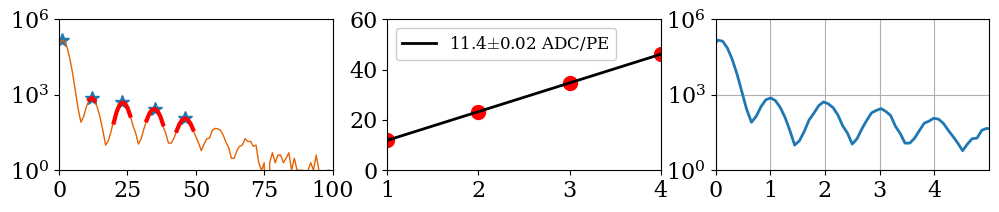

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_29.58OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


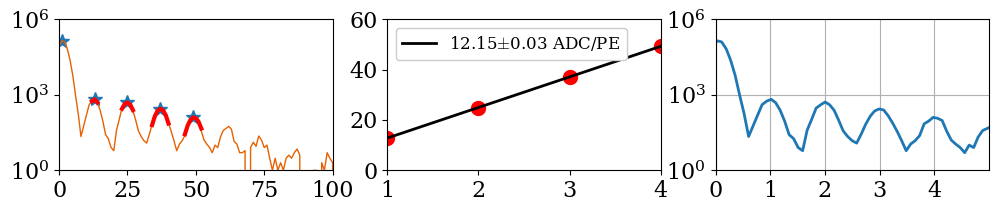

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_29.78OV_0.h5


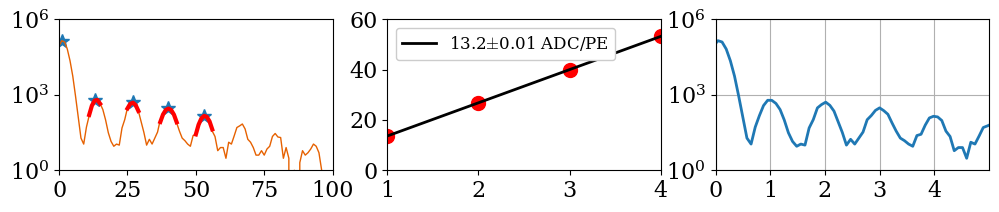

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_29.98OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


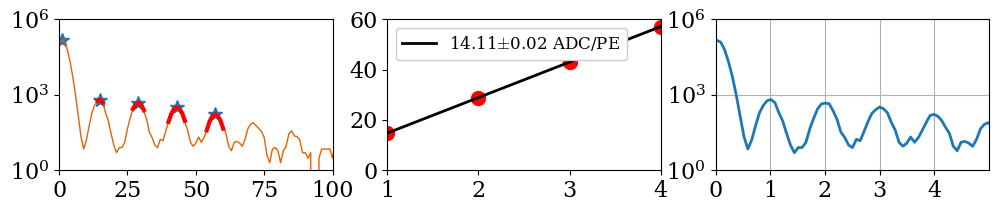

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_30.18OV_0.h5


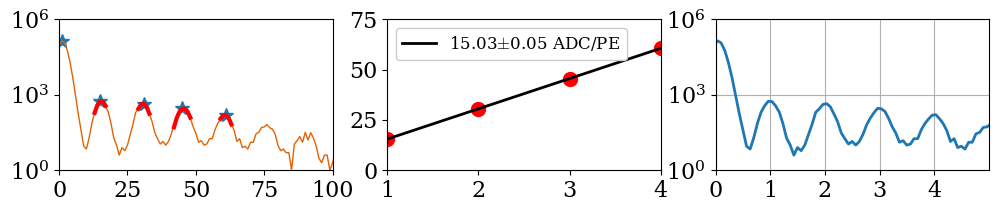

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_30.38OV_0.h5


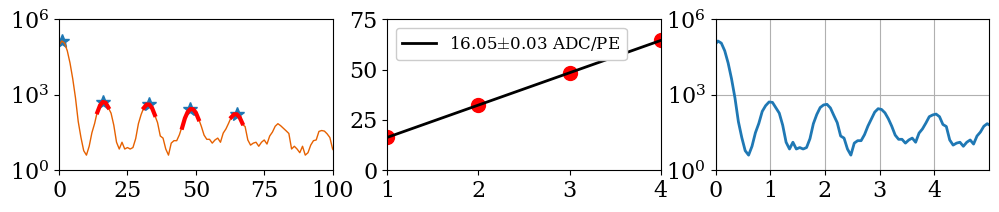

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_30.58OV_0.h5


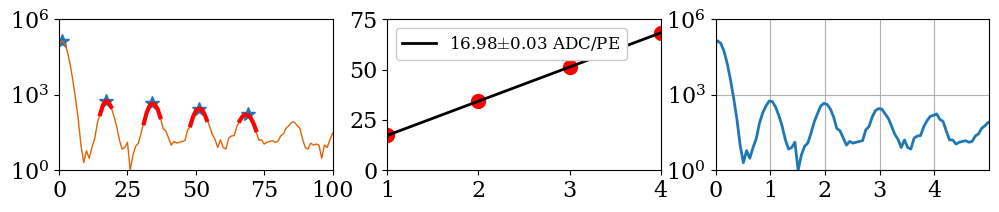

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_30.78OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


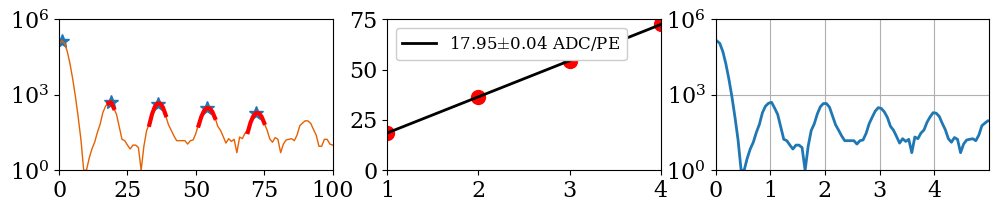

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_30.98OV_0.h5


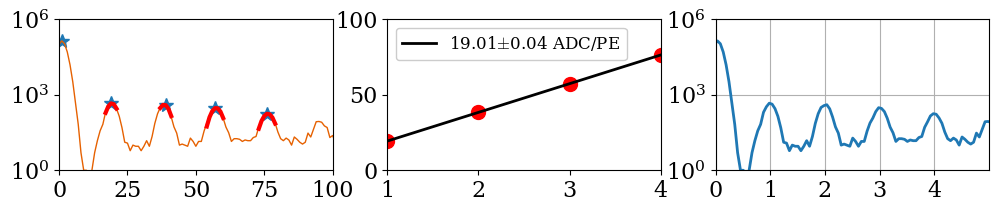

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_31.18OV_0.h5


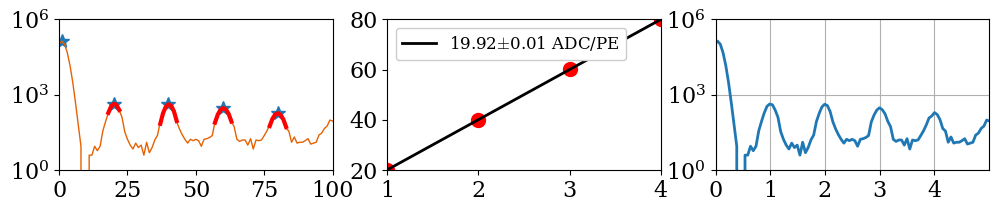

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_31.38OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


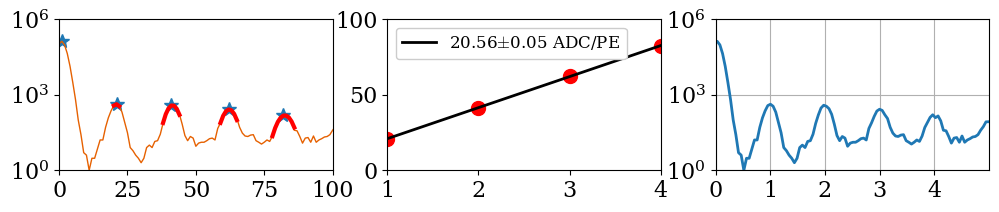

In [10]:
Step_1_calib_pe,Step_1_calib_count,Step_1_gain_list,Step_1_gain_err=gain_calculator(Step_1,40,4,10)
Voltages_Step_1=Voltages(Step_1)

In [11]:
##Step_2

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_29.38OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


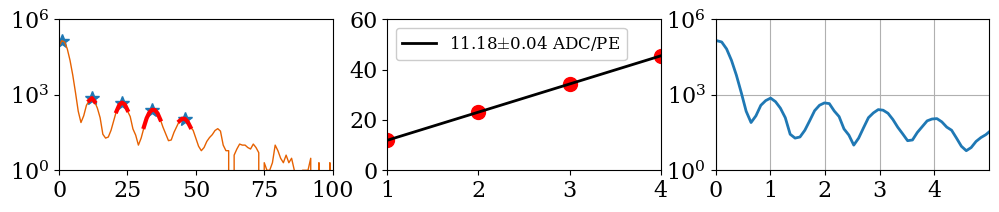

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_29.58OV_0.h5


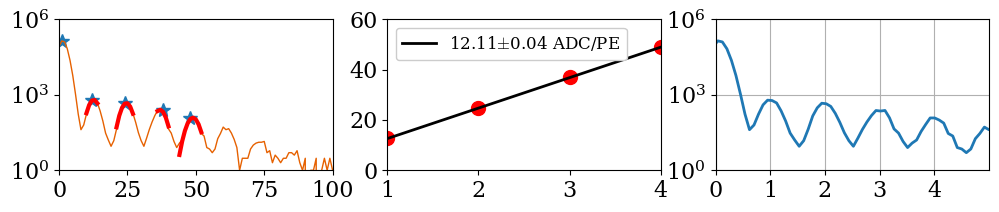

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_29.78OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


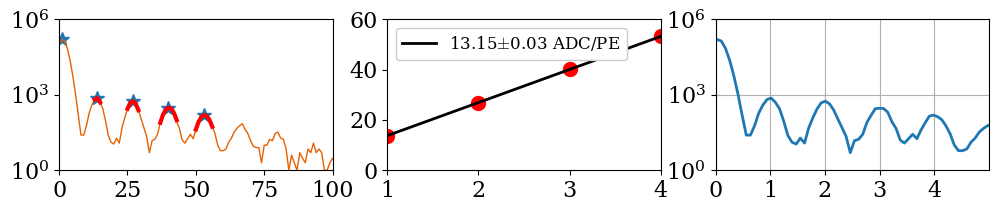

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_29.98OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


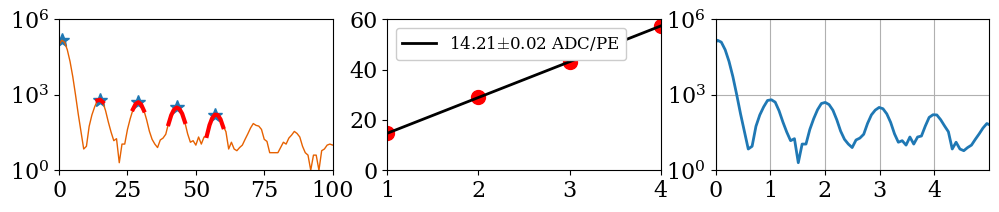

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_30.18OV_0.h5


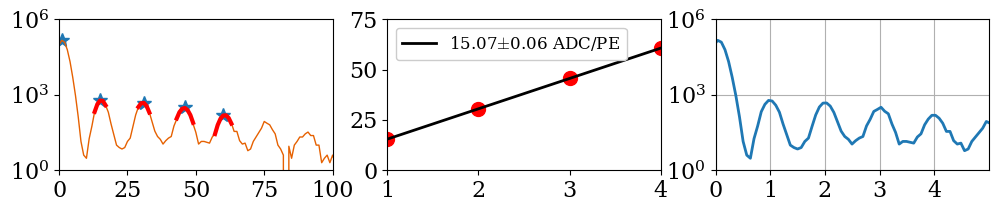

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_30.38OV_0.h5


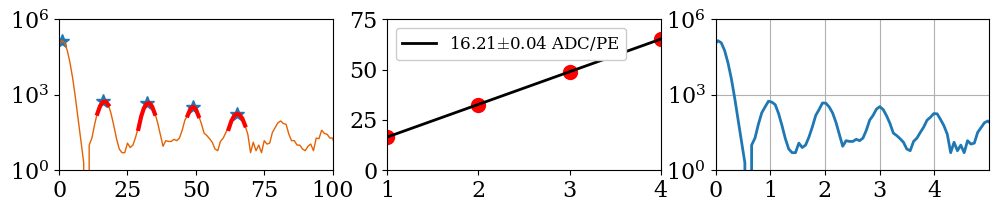

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_30.58OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


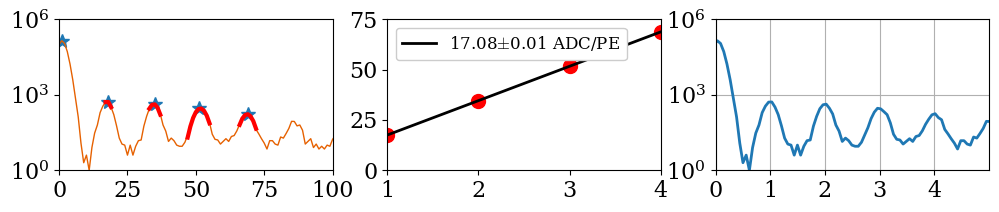

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_30.78OV_0.h5


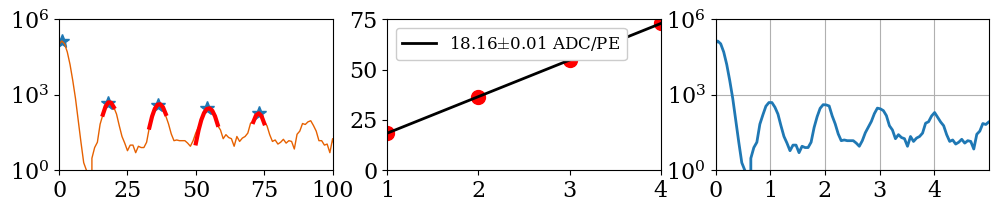

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_30.98OV_0.h5


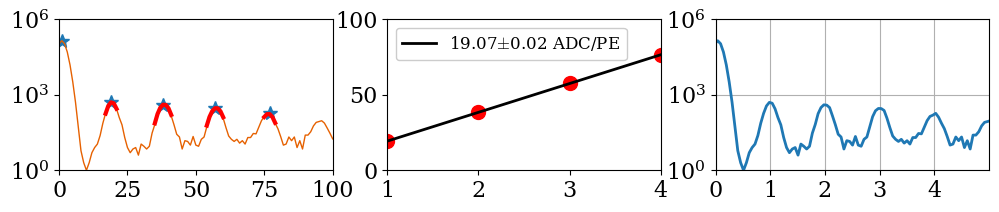

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_31.18OV_0.h5


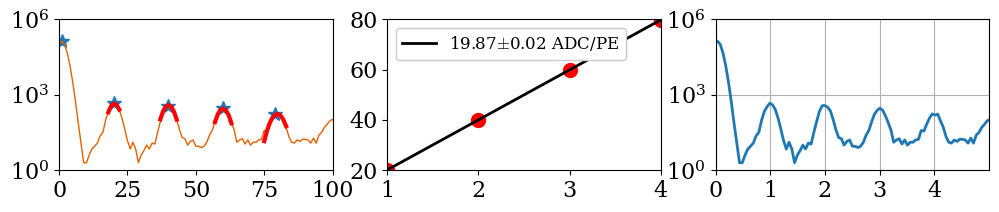

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_20min_-109C_setpoint/mca_keith_31.38OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


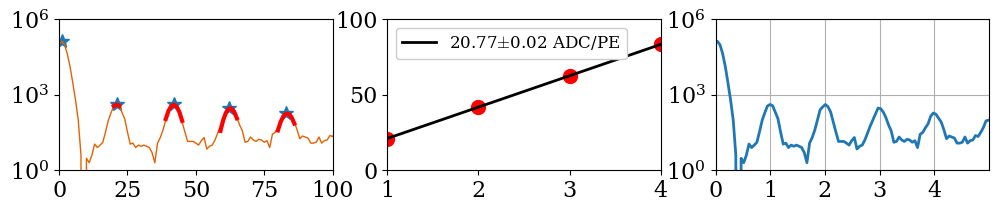

In [12]:
Step_2_calib_pe,Step_2_calib_count,Step_2_gain_list,Step_2_gain_err=gain_calculator(Step_2,40,4,10)
Voltages_Step_2=Voltages(Step_2)

Step_3

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source/mca_keith_29.78OV_0.h5


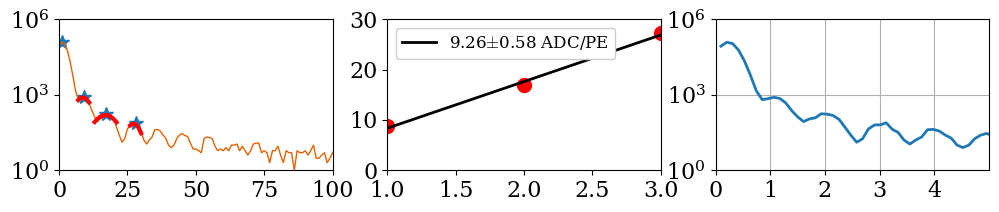

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source/mca_keith_29.98OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


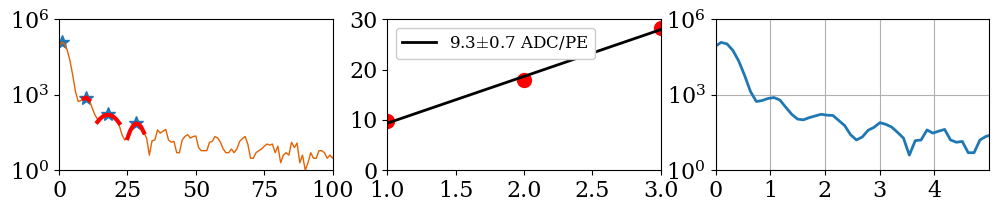

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source/mca_keith_30.18OV_0.h5


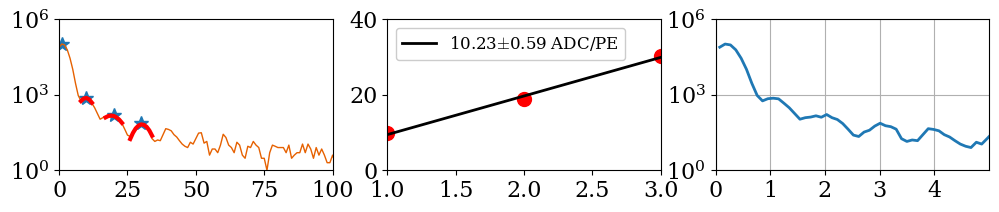

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source/mca_keith_30.38OV_0.h5


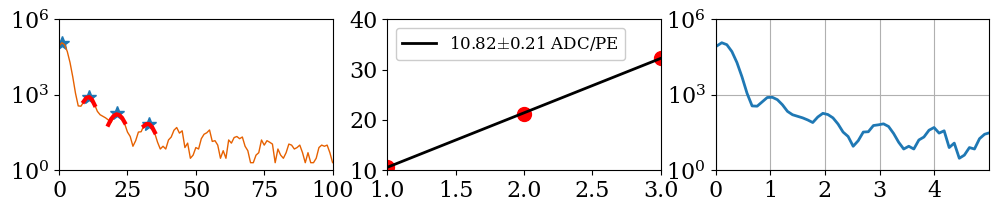

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source/mca_keith_30.58OV_0.h5


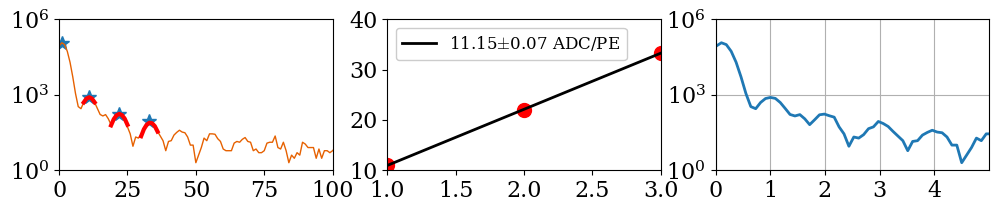

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source/mca_keith_30.78OV_0.h5


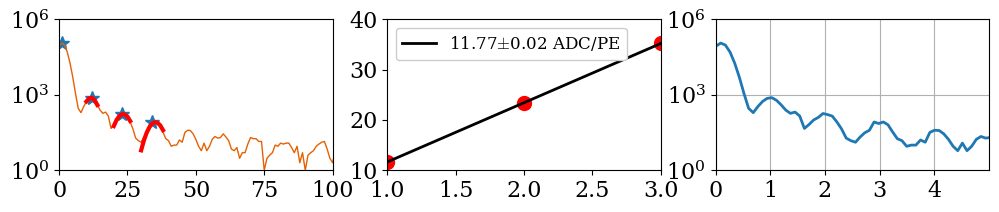

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source/mca_keith_30.98OV_0.h5


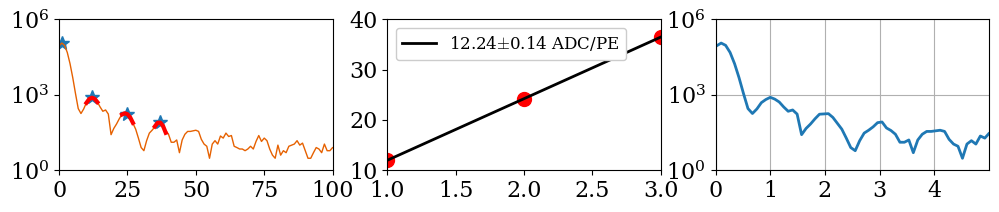

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source/mca_keith_31.18OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


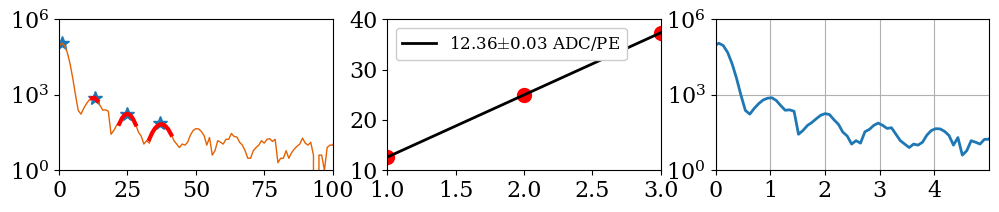

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source/mca_keith_31.38OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


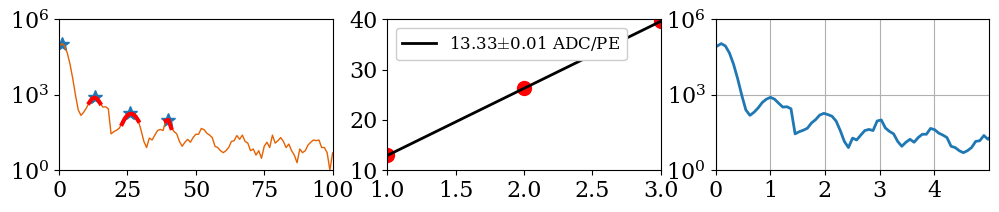

In [13]:
Step_3_calib_pe,Step_3_calib_count,Step_3_gain_list,Step_3_gain_err=gain_calculator(Step_3,40,3,7,2)
Voltages_Step_3=Voltages(Step_3)[2:]

## Step_4

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Gain_after_0V/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


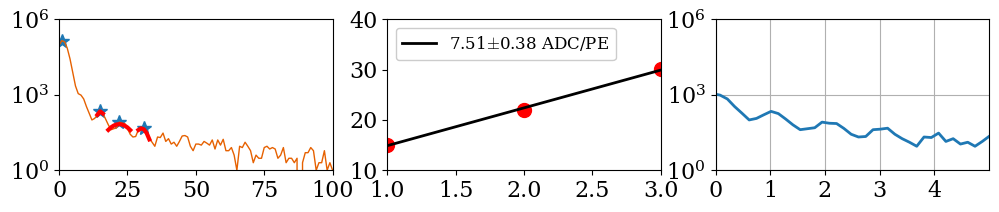

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Gain_after_0V/mca_keith_29.60OV_0.h5


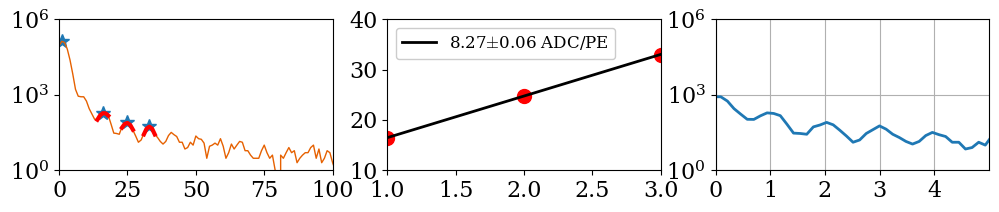

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Gain_after_0V/mca_keith_29.80OV_0.h5


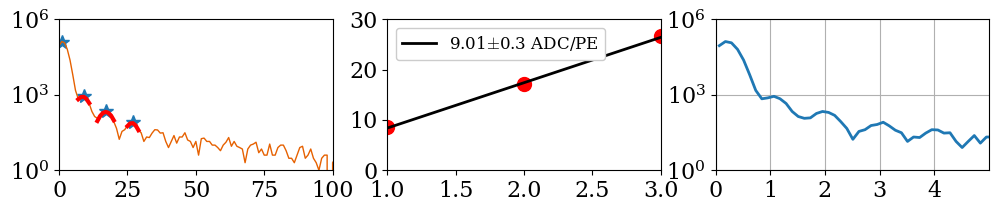

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Gain_after_0V/mca_keith_30.00OV_0.h5


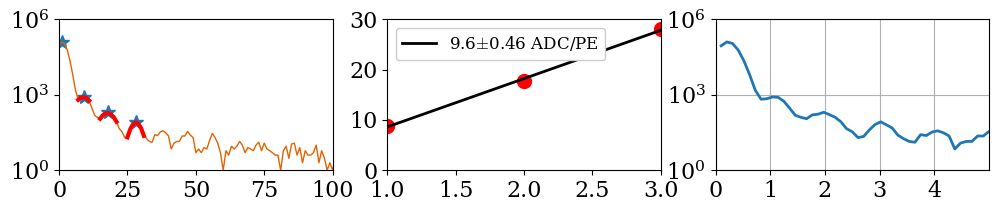

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Gain_after_0V/mca_keith_30.20OV_0.h5


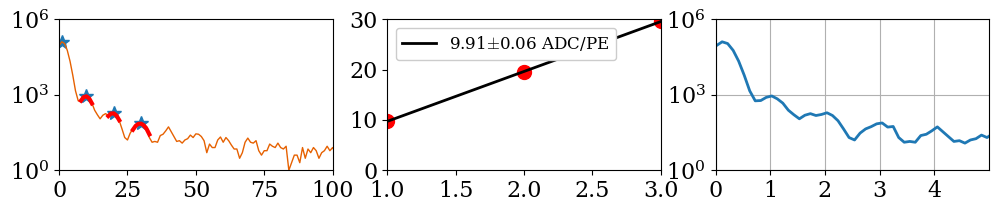

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Gain_after_0V/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


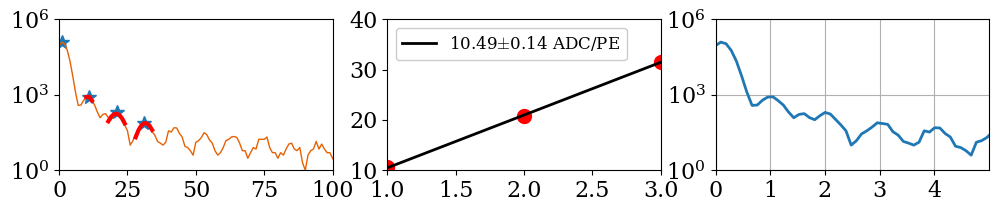

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Gain_after_0V/mca_keith_30.60OV_0.h5


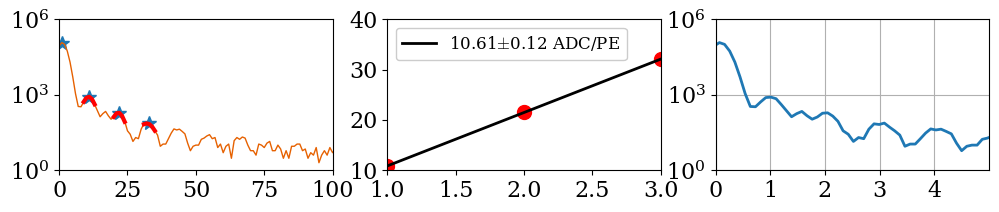

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Gain_after_0V/mca_keith_30.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


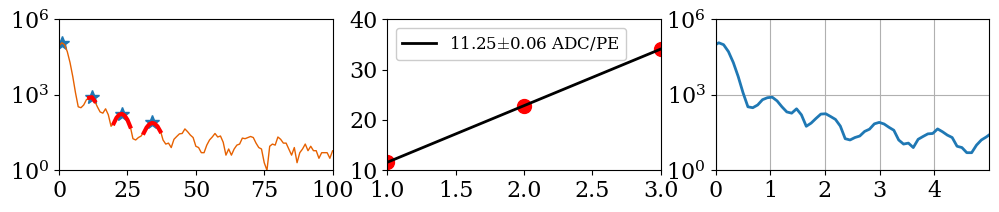

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Gain_after_0V/mca_keith_31.00OV_0.h5


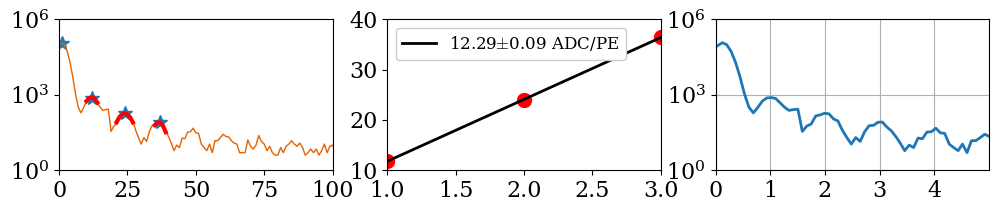

In [14]:
Step_4_calib_pe,Step_4_calib_count,Step_4_gain_list,Step_4_gain_err=gain_calculator(Step_4,40,3,7,2)
Voltages_Step_4=Voltages(Step_4)[2:]

## Step_5

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_29.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


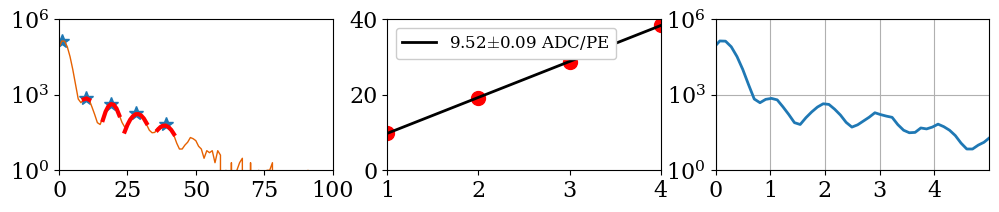

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_29.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


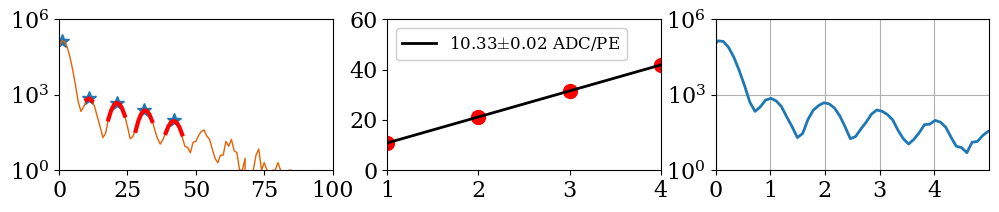

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


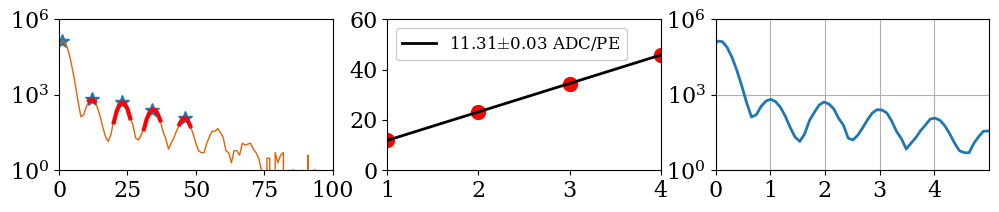

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_29.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


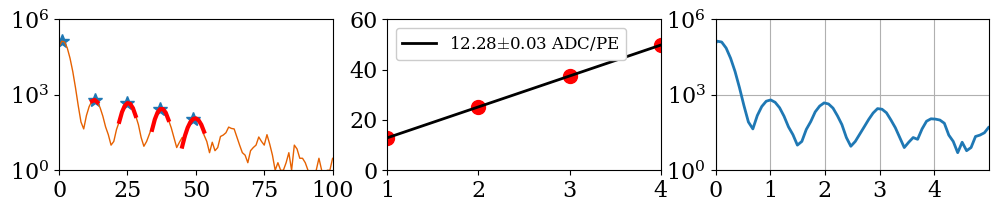

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_29.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


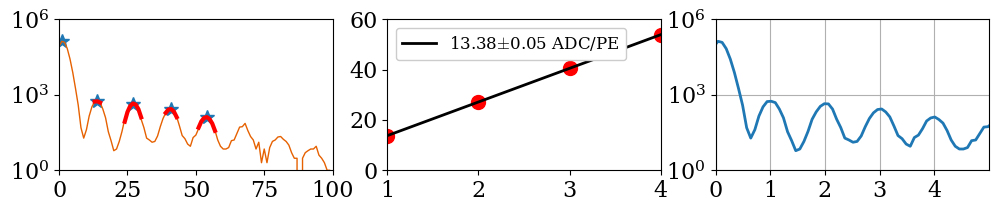

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_30.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


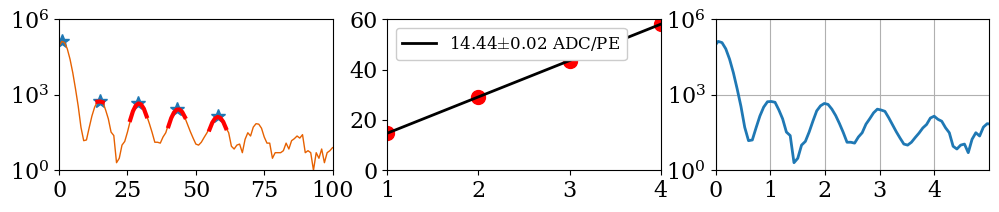

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_30.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


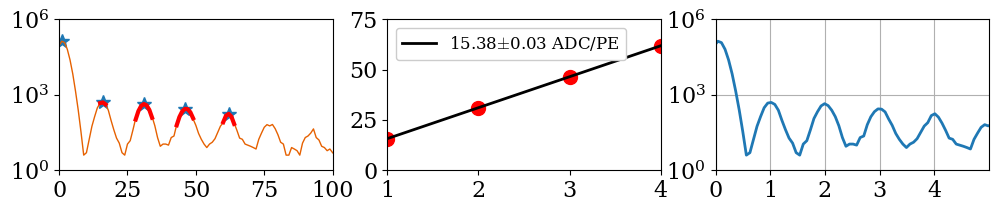

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


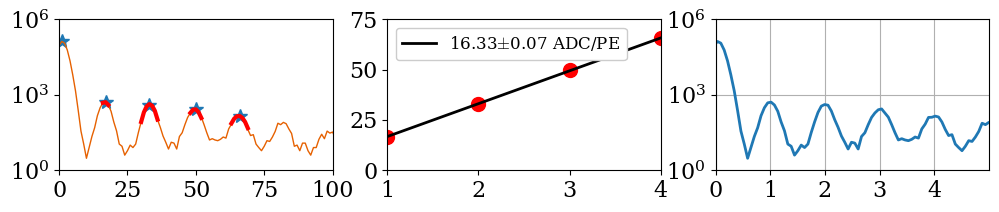

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_30.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


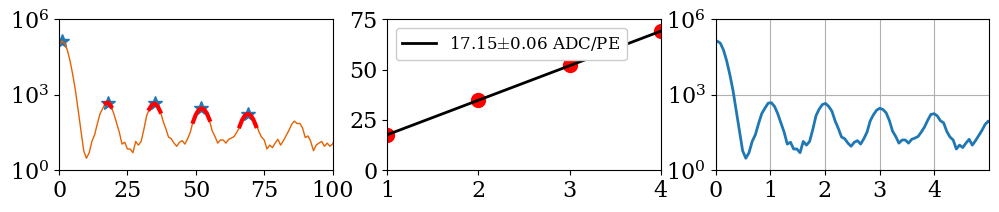

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_30.80OV_0.h5


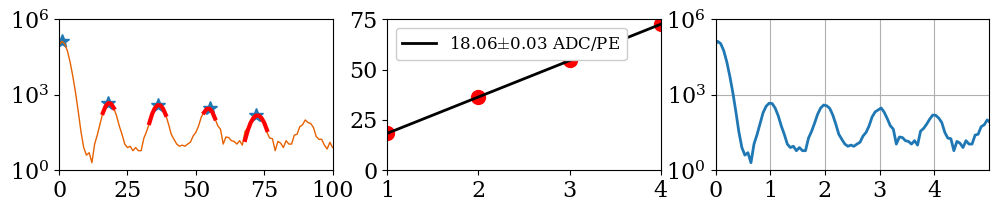

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_31.00OV_0.h5


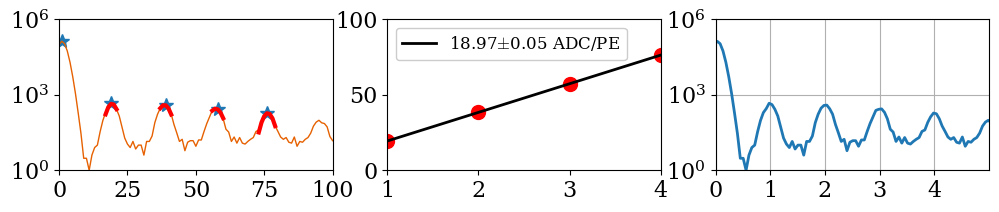

In [15]:
Step_5_calib_pe,Step_5_calib_count,Step_5_gain_list,Step_5_gain_err=gain_calculator(Step_5,40,4,1)
Voltages_Step_5=Voltages(Step_5)

## Step_6

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_29.00OV_0.h5


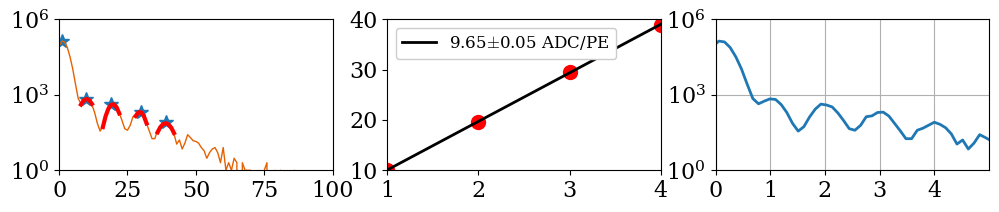

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_29.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


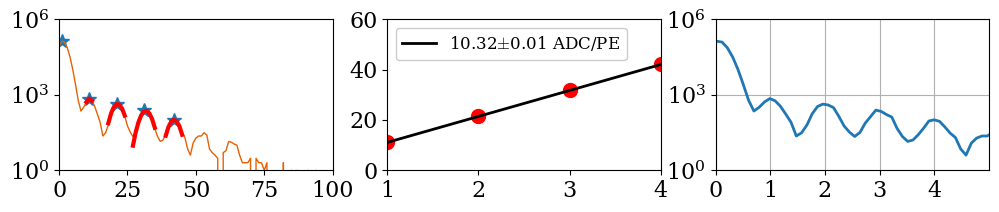

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


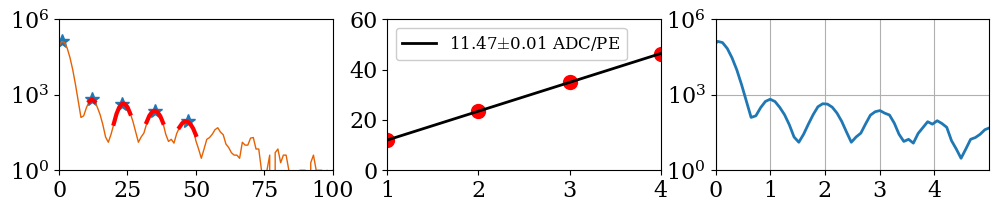

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_29.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


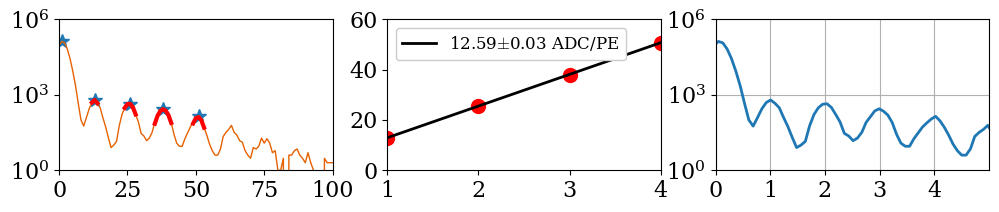

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_29.80OV_0.h5


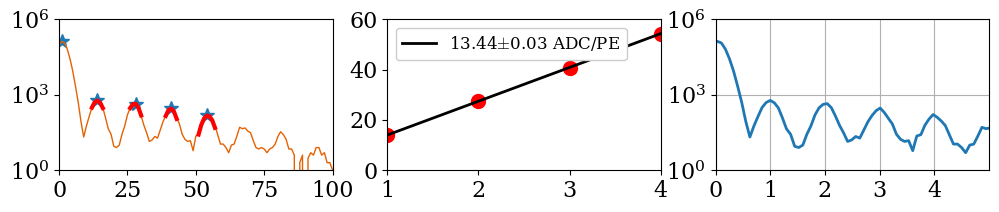

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_30.00OV_0.h5


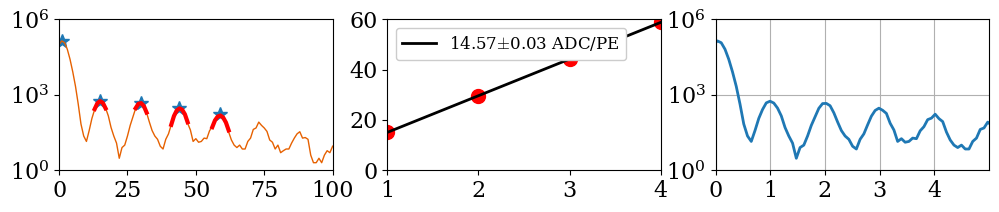

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_30.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


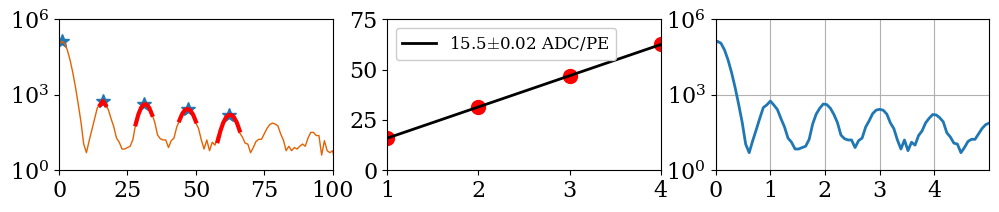

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


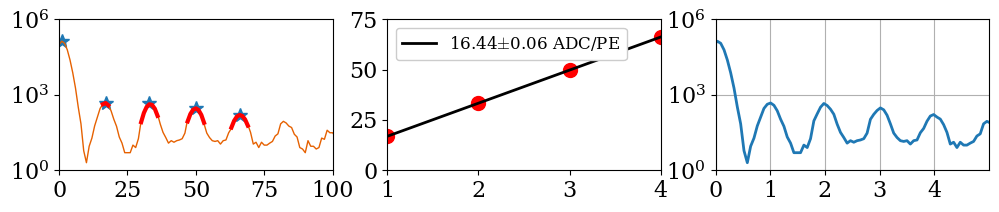

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_30.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


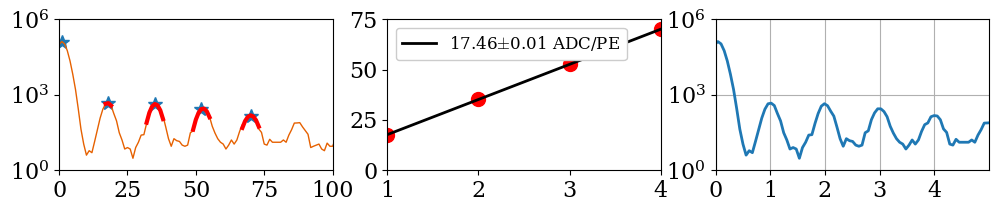

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_30.80OV_0.h5


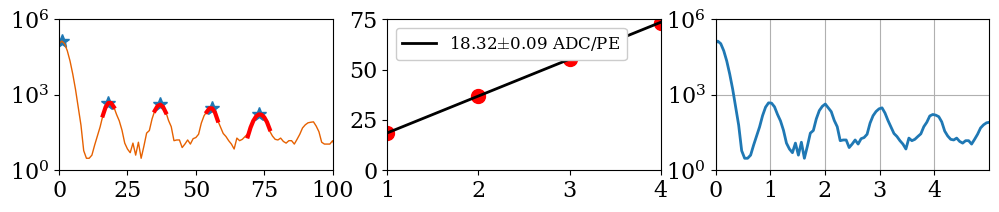

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_31.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


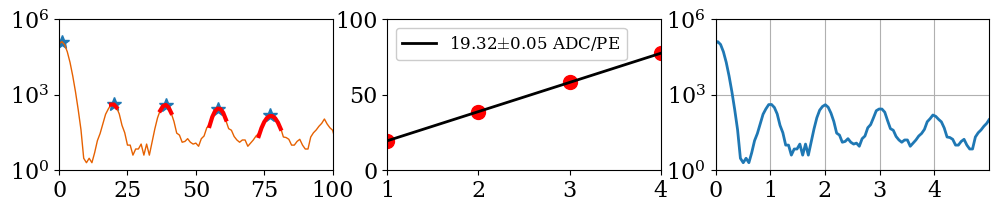

In [16]:
Step_6_calib_pe,Step_6_calib_count,Step_6_gain_list,Step_6_gain_err=gain_calculator(Step_6,40,4,1)
Voltages_Step_6=Voltages(Step_6)

## Step_7

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain/mca_keith_29.40OV_0.h5


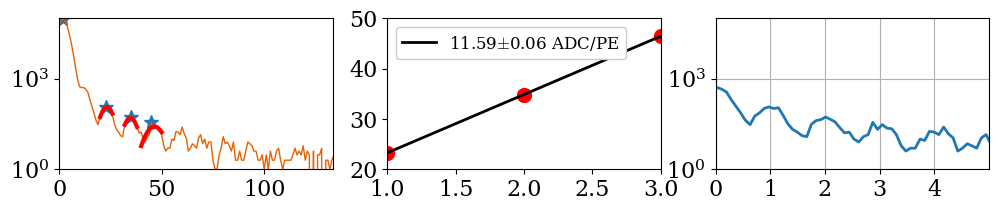

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain/mca_keith_29.60OV_0.h5


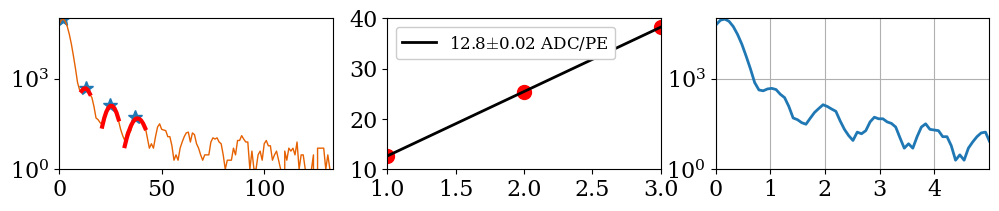

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain/mca_keith_29.80OV_0.h5


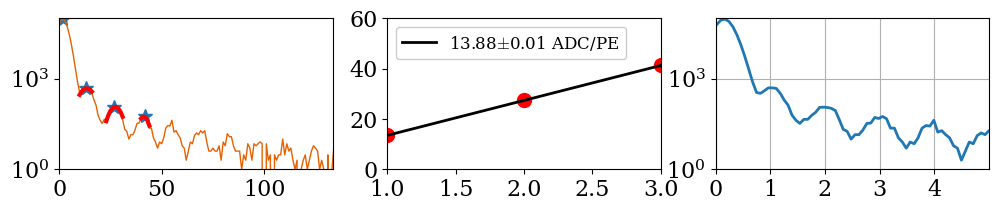

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain/mca_keith_30.00OV_0.h5


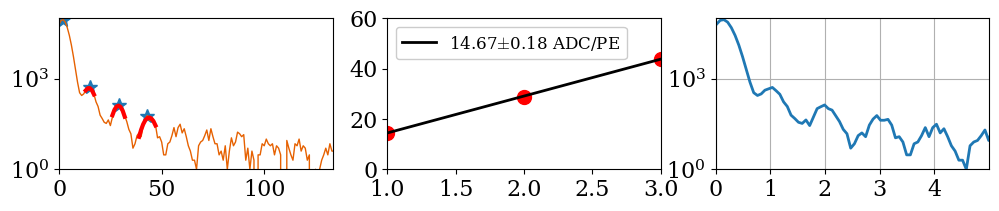

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain/mca_keith_30.20OV_0.h5


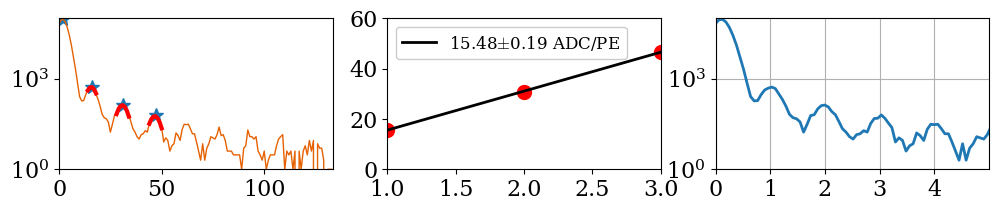

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain/mca_keith_30.40OV_0.h5


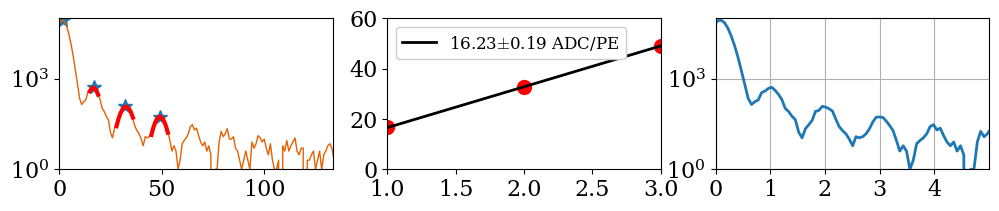

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain/mca_keith_30.60OV_0.h5


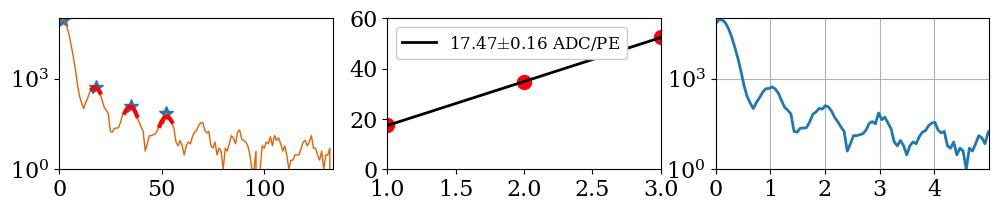

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain/mca_keith_30.80OV_0.h5


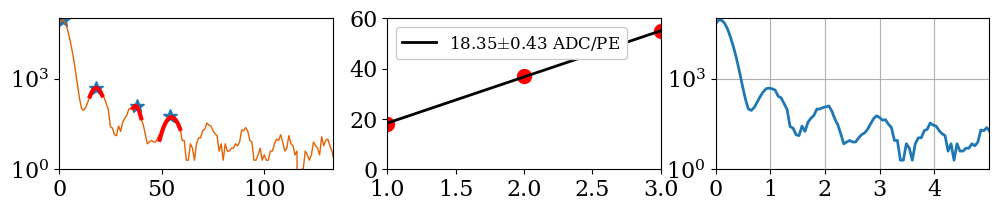

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain/mca_keith_31.00OV_0.h5


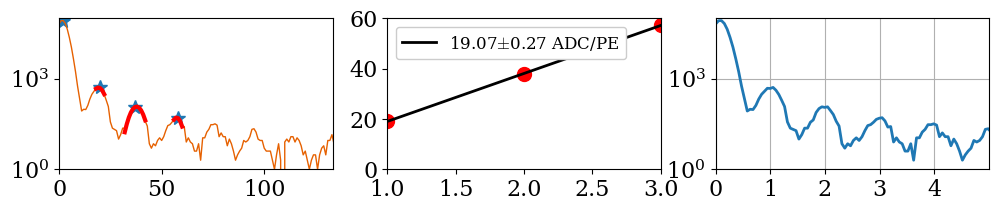

In [17]:
Step_7_calib_pe,Step_7_calib_count,Step_7_gain_list,Step_7_gain_err=gain_calculator(Step_7,30,3,10,2)
Voltages_Step_7=Voltages(Step_7)[2:]

## Step_8

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/mca_keith_29.20OV_0.h5


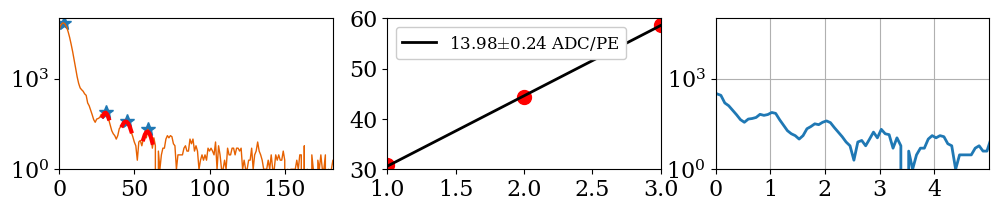

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/mca_keith_29.40OV_0.h5


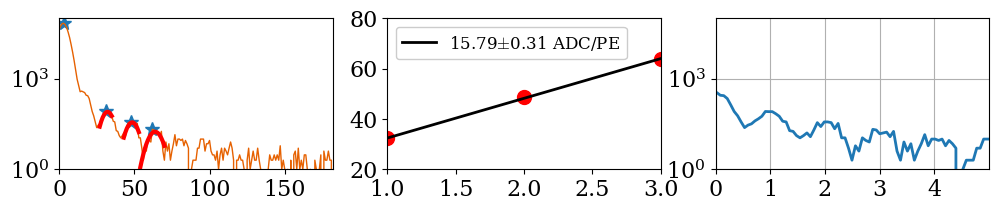

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/mca_keith_29.60OV_0.h5


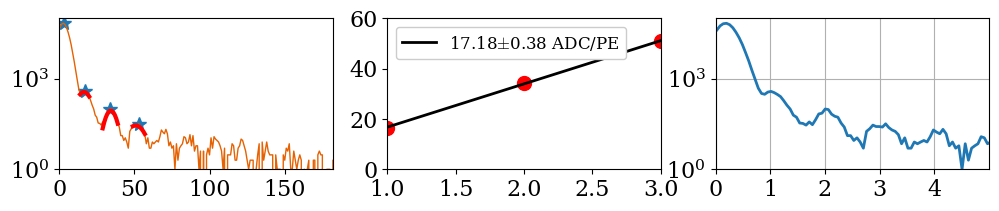

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/mca_keith_29.80OV_0.h5


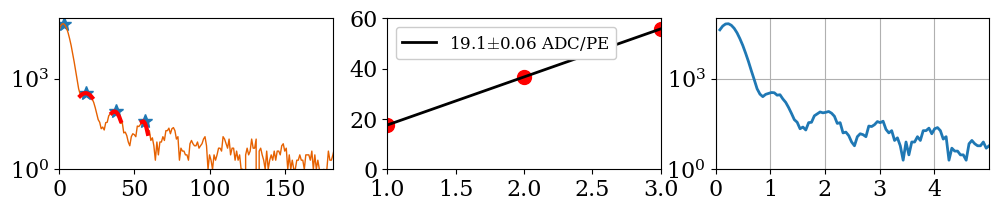

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/mca_keith_30.00OV_0.h5


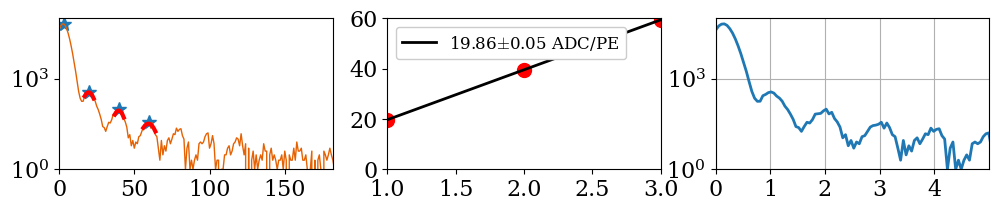

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/mca_keith_30.20OV_0.h5


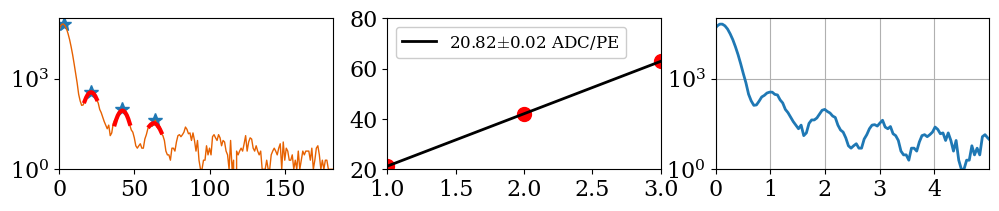

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/mca_keith_30.40OV_0.h5


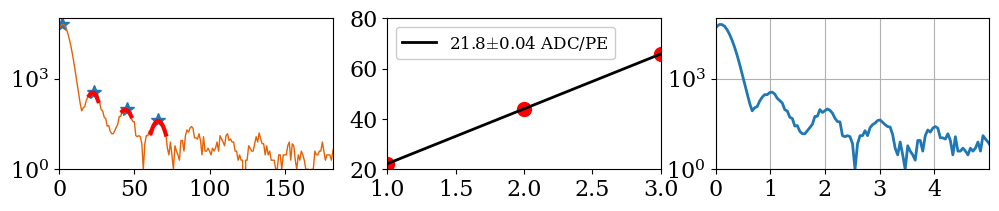

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/mca_keith_30.60OV_0.h5


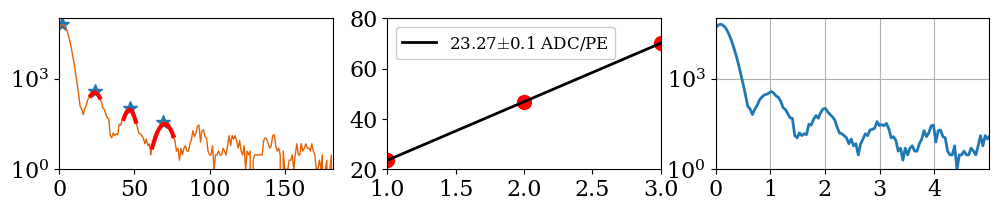

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/mca_keith_30.80OV_0.h5


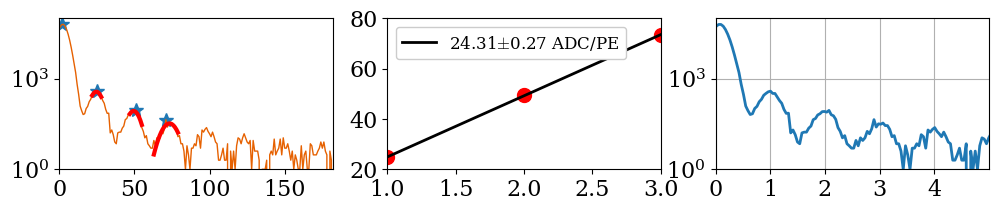

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/mca_keith_31.00OV_0.h5


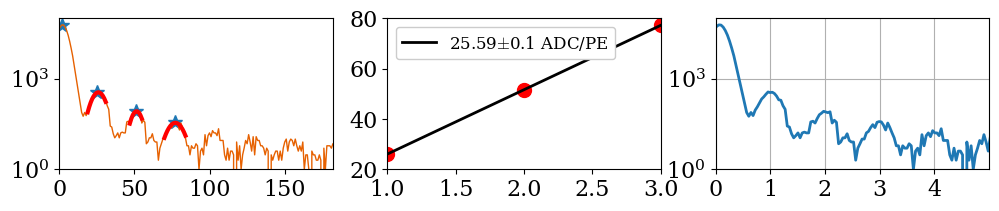

In [18]:
Step_8_calib_pe,Step_8_calib_count,Step_8_gain_list,Step_8_gain_err=gain_calculator(Step_8,22,3,10,1)
Voltages_Step_8=Voltages(Step_8)[1:]


## Step_9

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_29.00OV_0.h5


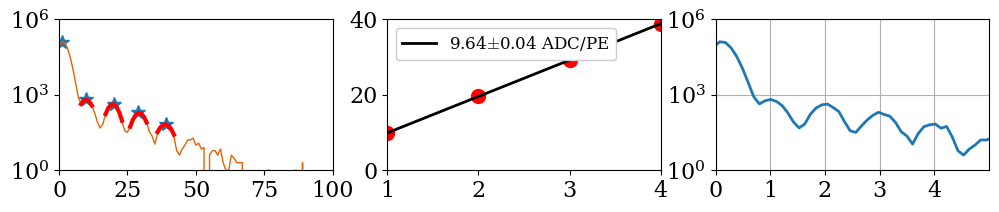

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_29.20OV_0.h5


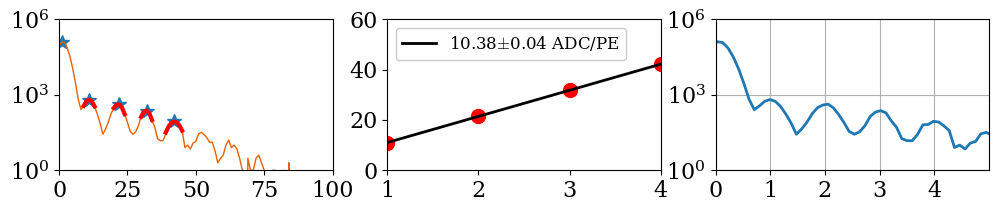

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


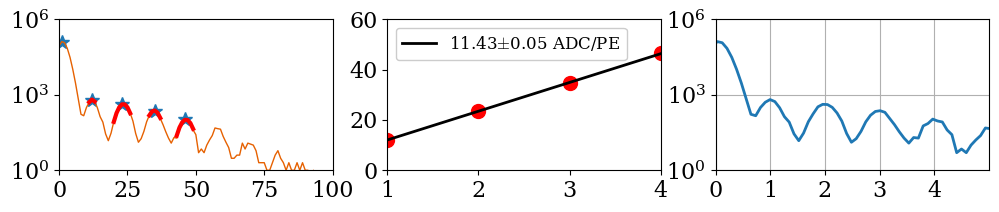

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_29.60OV_0.h5


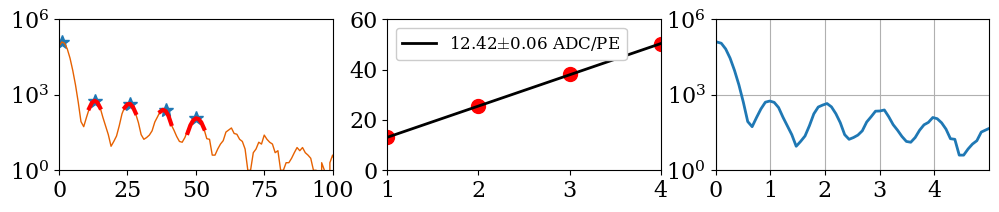

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_29.80OV_0.h5


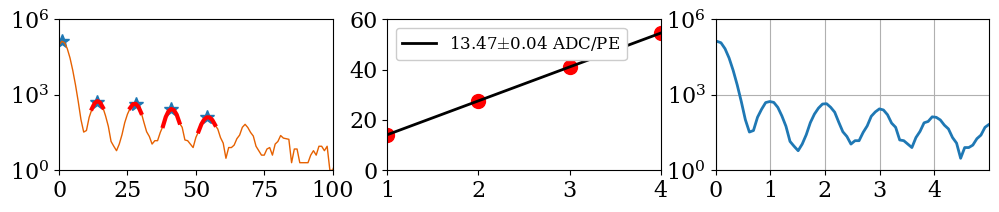

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_30.00OV_0.h5


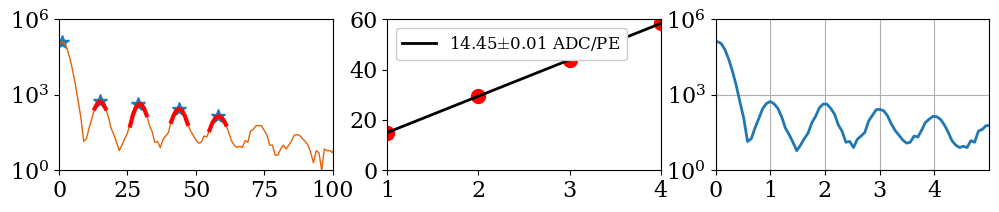

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_30.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


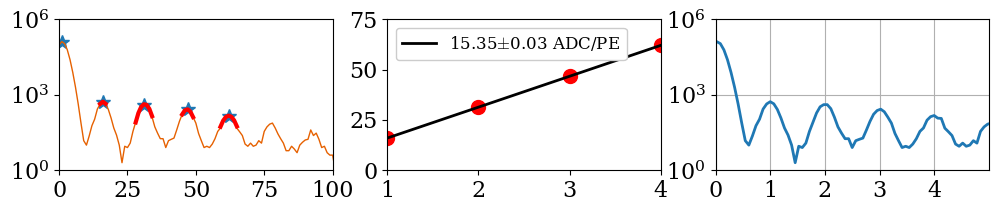

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_30.40OV_0.h5


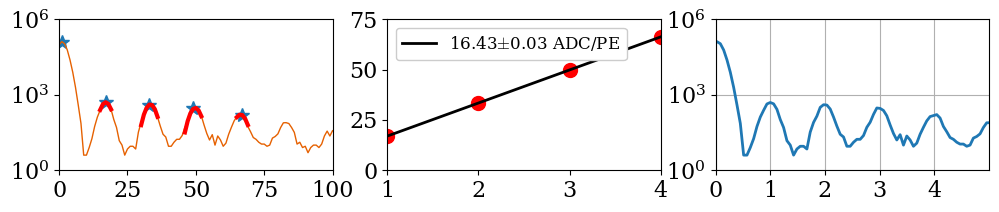

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_30.60OV_0.h5


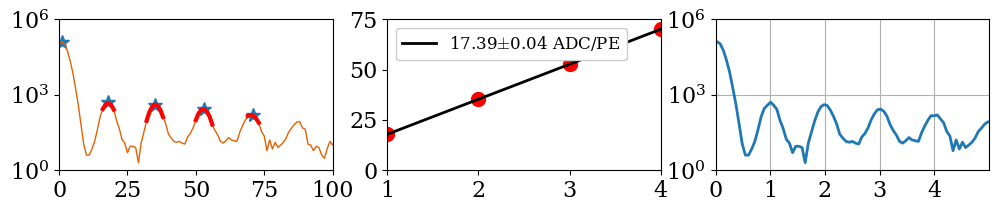

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_30.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


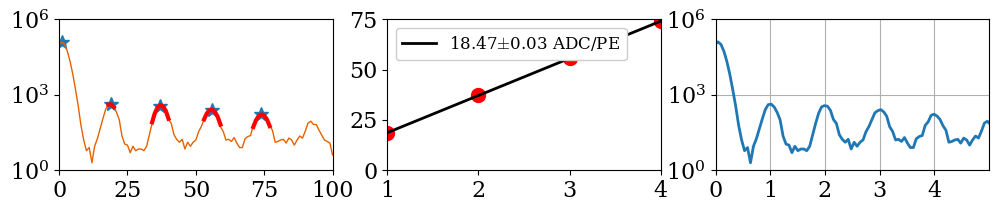

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_31.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


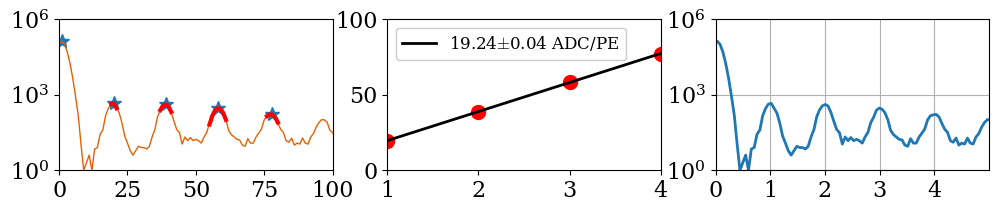

In [19]:
Step_9_calib_pe,Step_9_calib_count,Step_9_gain_list,Step_9_gain_err=gain_calculator(Step_9,40,4,1)
Voltages_Step_9=Voltages(Step_9)

In [20]:
## Step_10

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_29.00OV_0.h5


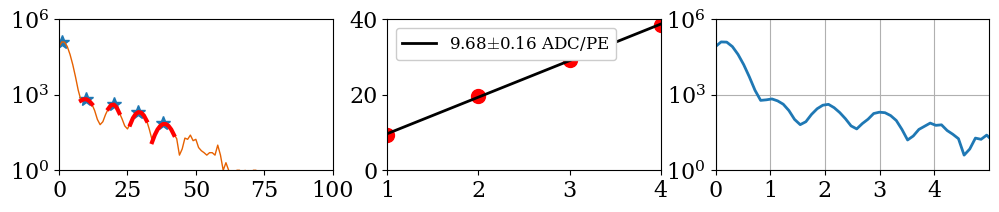

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_29.20OV_0.h5


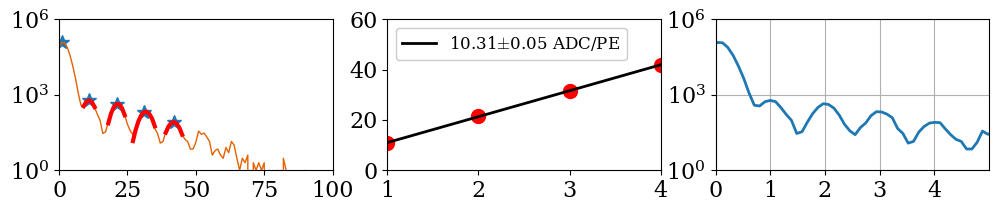

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_29.40OV_0.h5


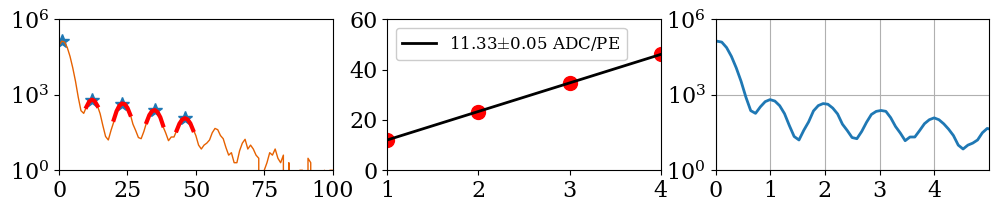

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_29.60OV_0.h5


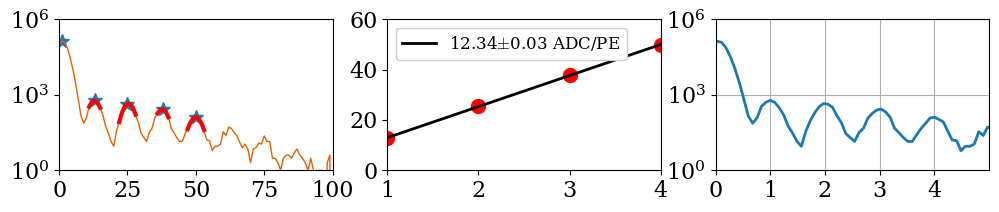

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_29.80OV_0.h5


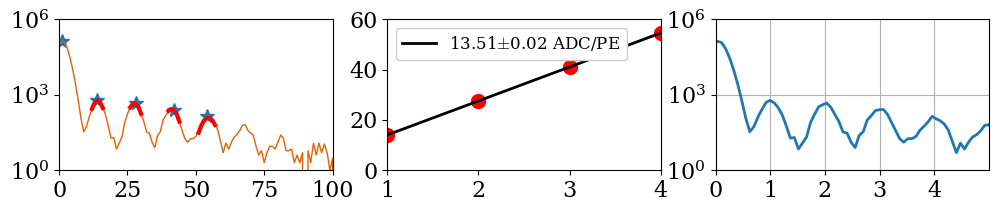

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_30.00OV_0.h5


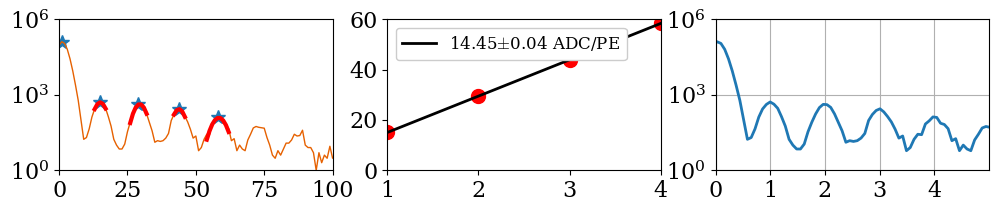

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_30.20OV_0.h5


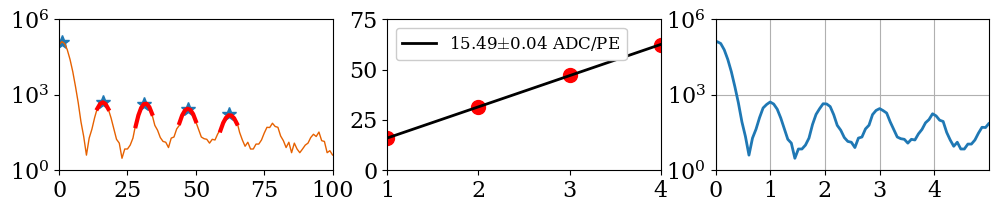

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


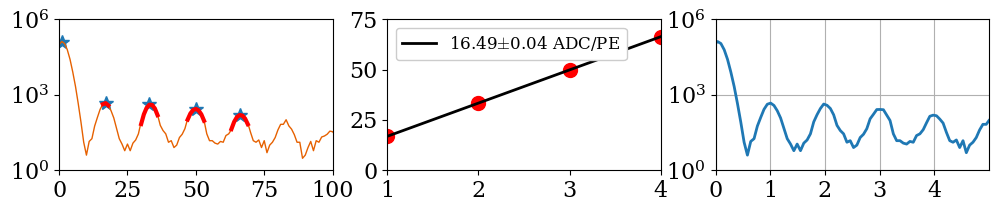

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_30.60OV_0.h5


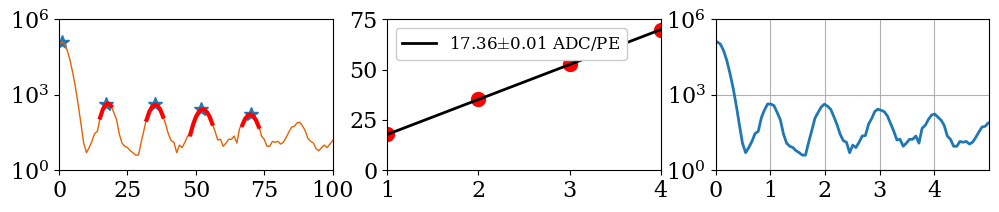

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_30.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


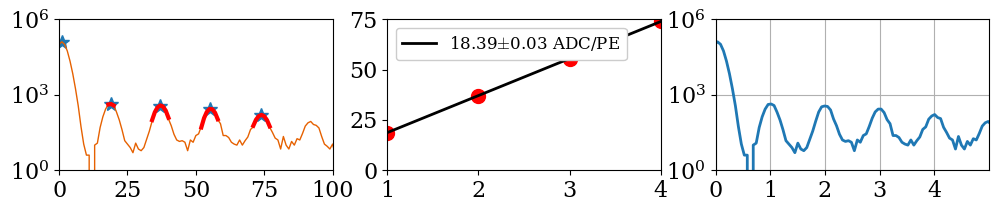

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_31.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


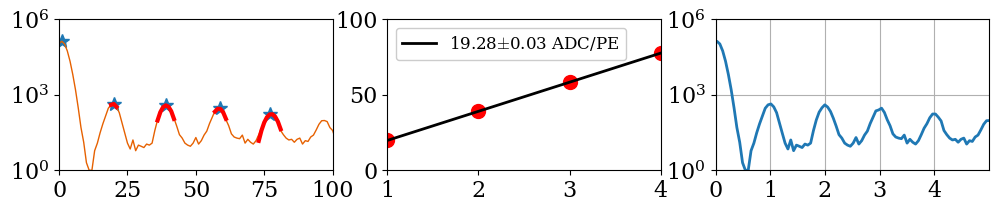

In [21]:
Step_10_calib_pe,Step_10_calib_count,Step_10_gain_list,Step_10_gain_err=gain_calculator(Step_10,40,4,1)
Voltages_Step_10=Voltages(Step_10)

## Step_11

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_29.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


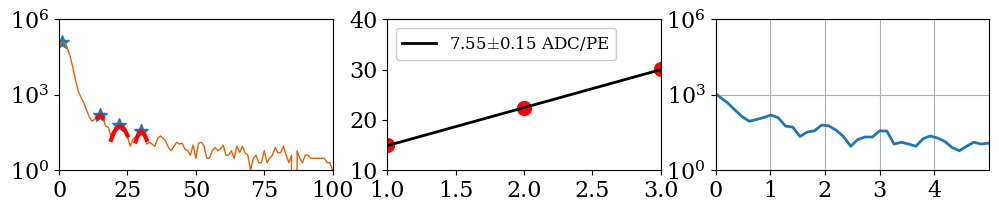

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_29.20OV_0.h5


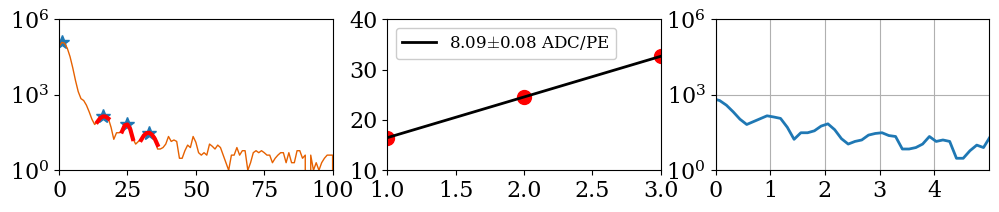

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


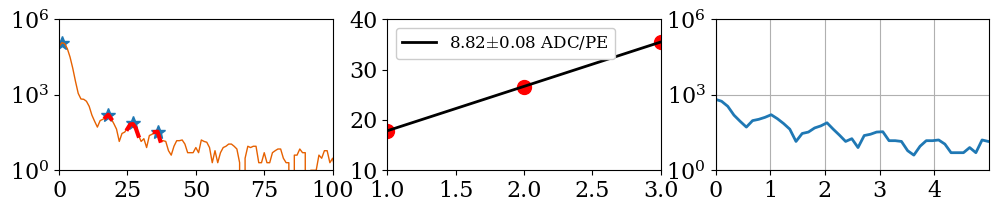

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_29.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


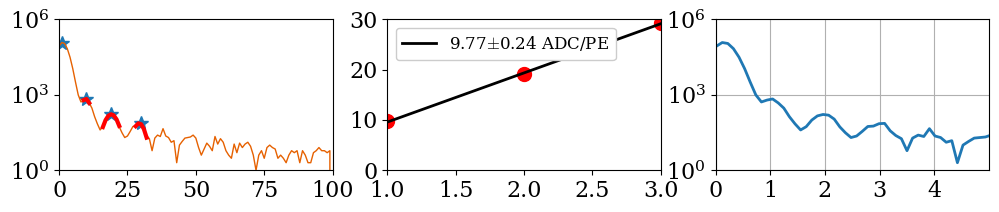

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_29.80OV_0.h5


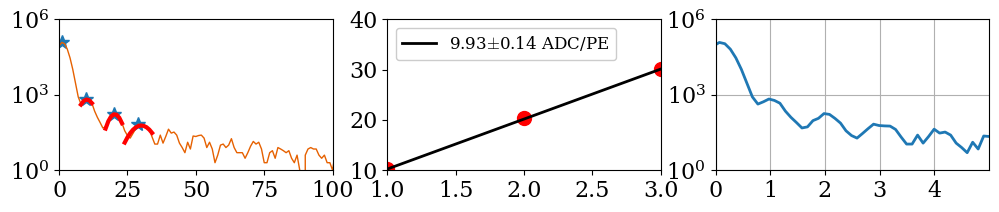

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_30.00OV_0.h5


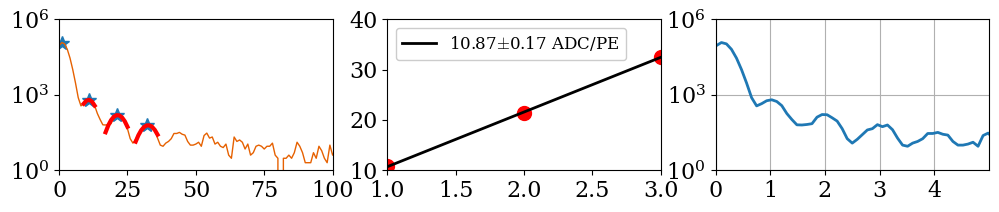

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_30.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


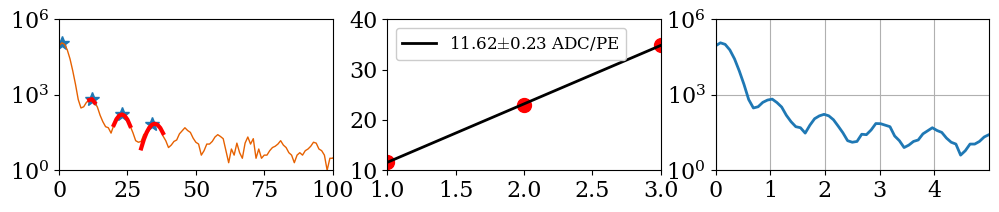

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_30.40OV_0.h5


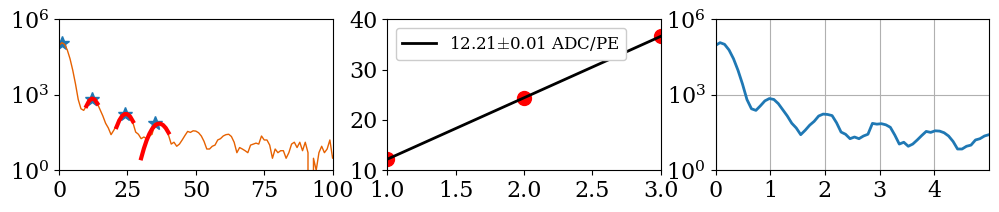

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_30.60OV_0.h5


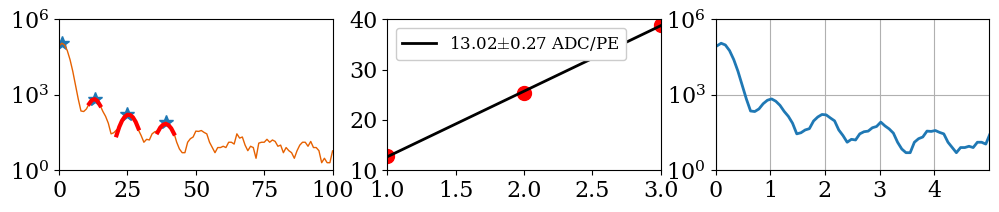

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_30.80OV_0.h5


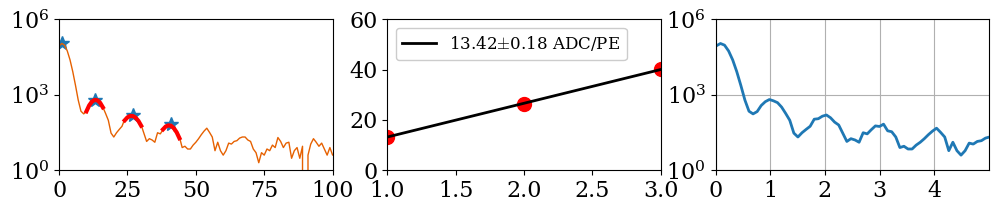

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain/mca_keith_31.00OV_0.h5


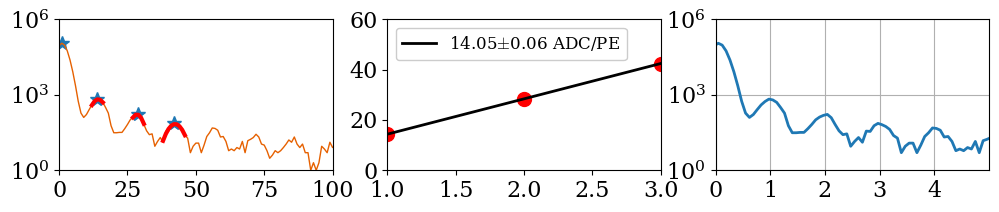

In [22]:
Step_11_calib_pe,Step_11_calib_count,Step_11_gain_list,Step_11_gain_err=gain_calculator(Step_11,40,3,1)
Voltages_Step_11=Voltages(Step_11)

## Step_12

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_gain_after/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


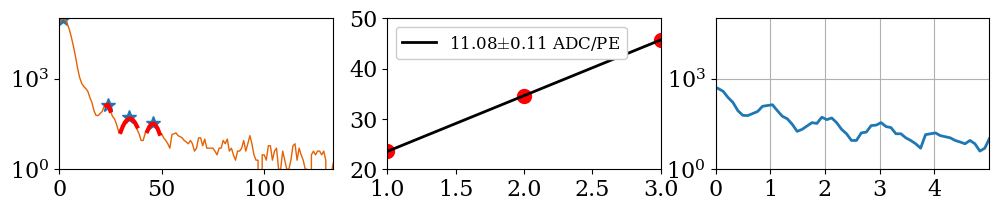

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_gain_after/mca_keith_29.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


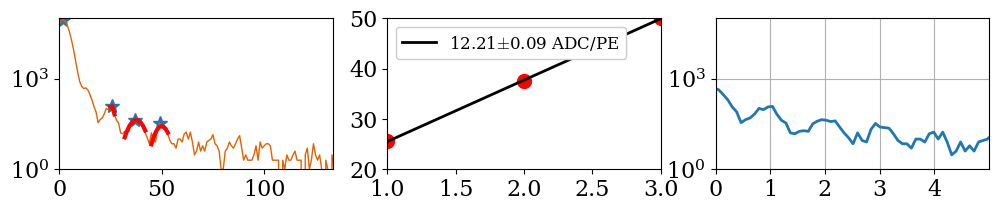

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_gain_after/mca_keith_29.80OV_0.h5


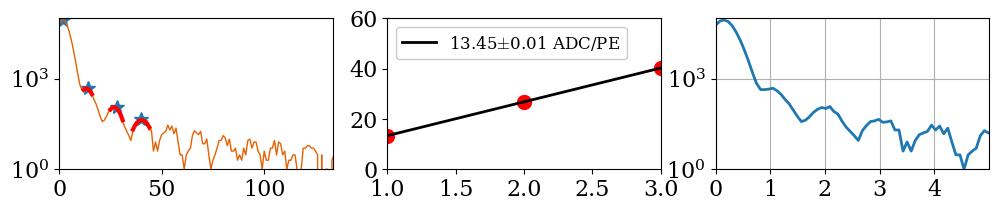

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_gain_after/mca_keith_30.00OV_0.h5


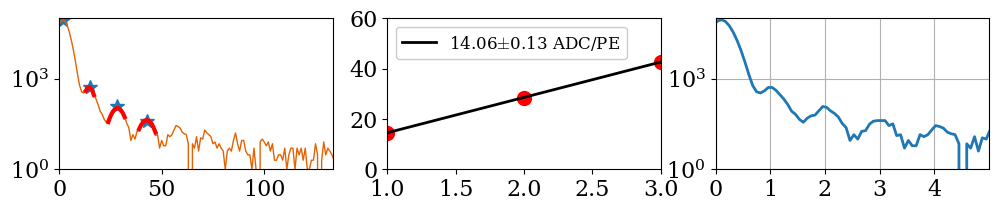

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_gain_after/mca_keith_30.20OV_0.h5


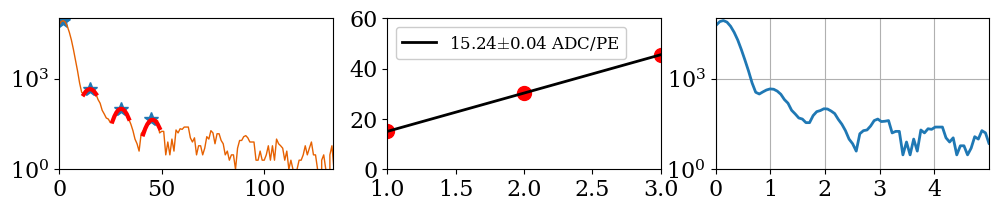

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_gain_after/mca_keith_30.40OV_0.h5


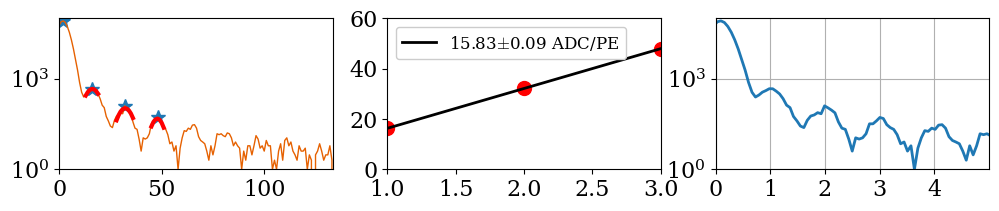

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_gain_after/mca_keith_30.60OV_0.h5


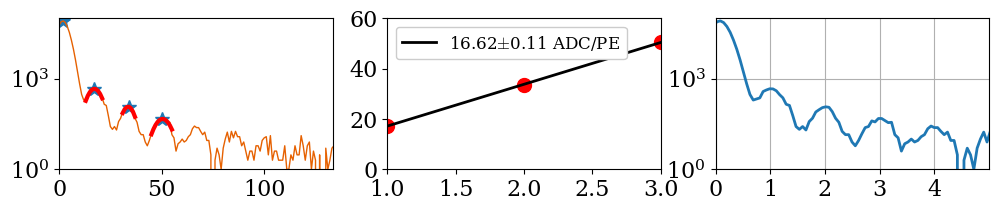

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_gain_after/mca_keith_30.80OV_0.h5


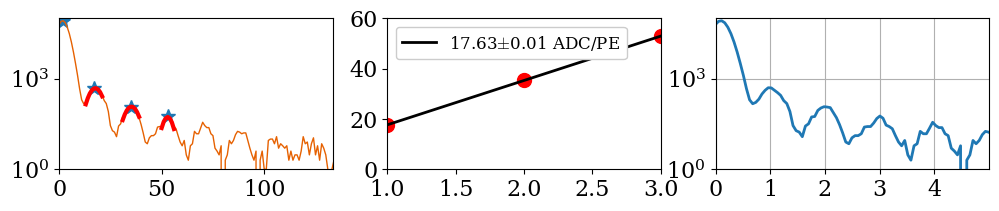

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_gain_after/mca_keith_31.00OV_0.h5


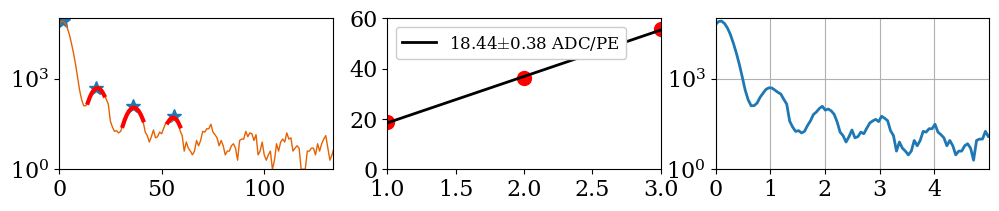

In [23]:
Step_12_calib_pe,Step_12_calib_count,Step_12_gain_list,Step_12_gain_err=gain_calculator(Step_12,30,3,3,2)
Voltages_Step_12=Voltages(Step_12)[2:]

In [24]:
## Step_13

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_29.00OV_0.h5


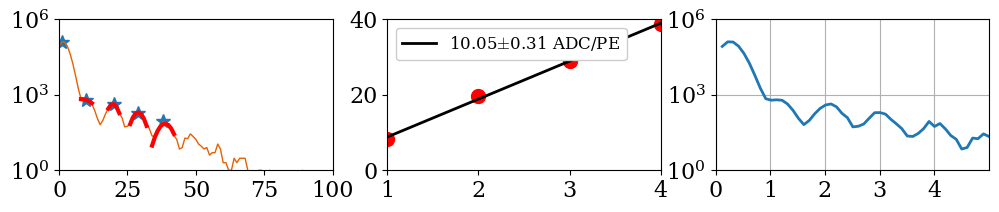

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_29.20OV_0.h5


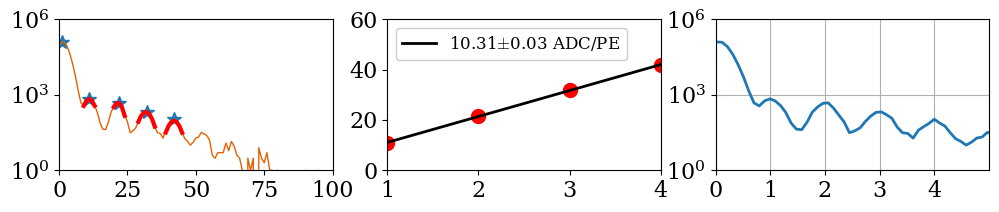

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_29.40OV_0.h5


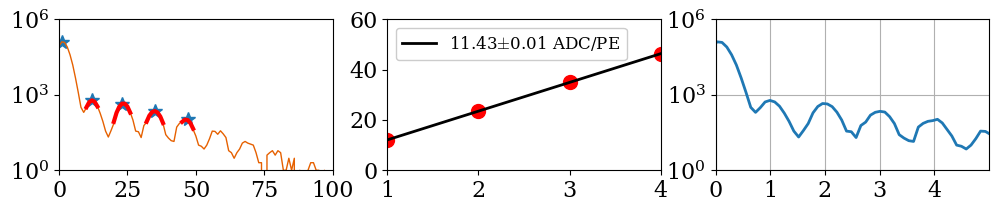

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_29.60OV_0.h5


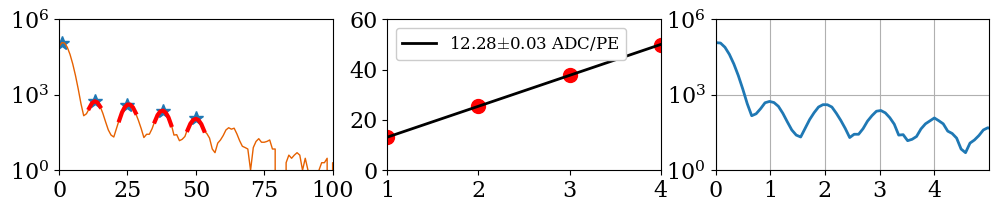

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_29.80OV_0.h5


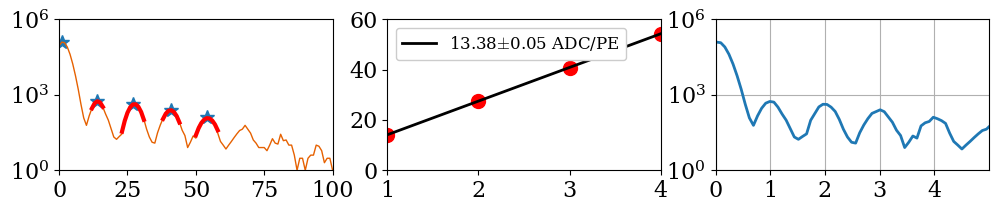

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_30.00OV_0.h5


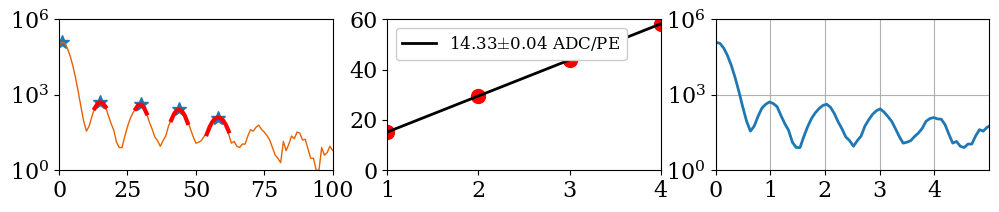

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_30.20OV_0.h5


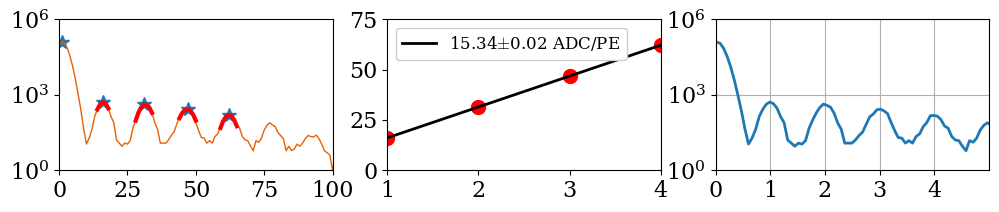

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_30.40OV_0.h5


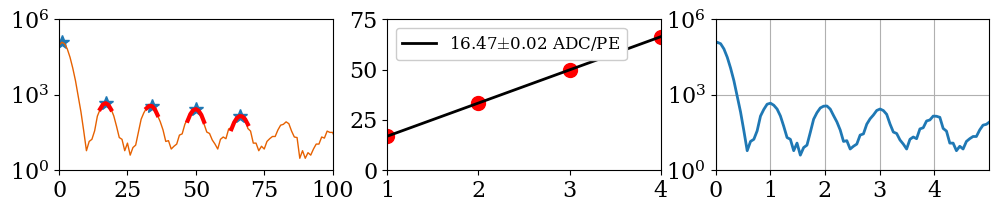

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_30.60OV_0.h5


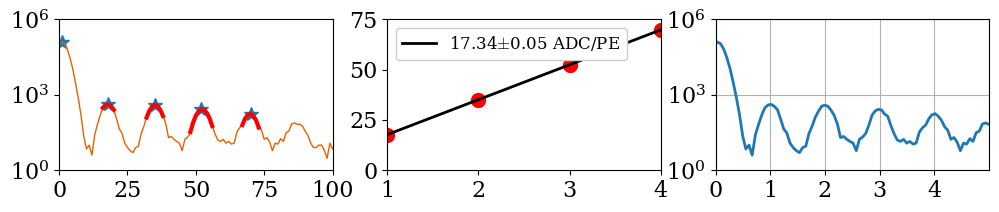

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_30.80OV_0.h5


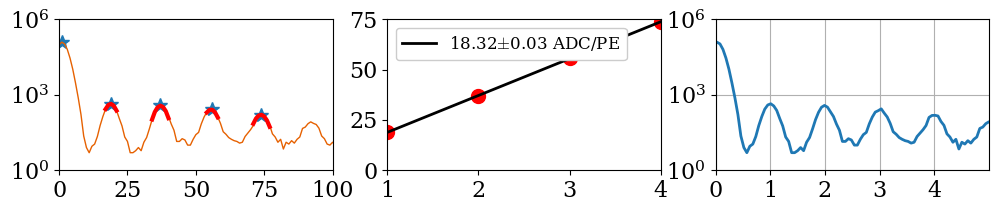

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_31.00OV_0.h5


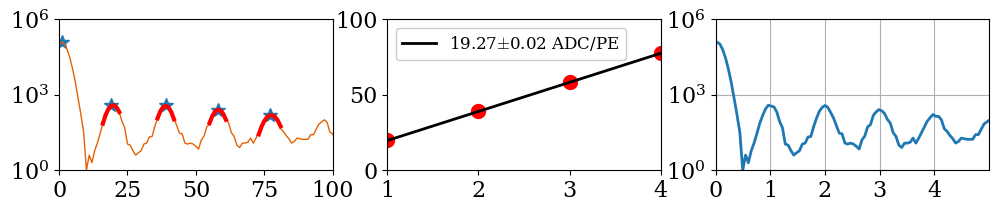

In [25]:
Step_13_calib_pe,Step_13_calib_count,Step_13_gain_list,Step_13_gain_err=gain_calculator(Step_13,40,4,1)
Voltages_Step_13=Voltages(Step_13)

In [26]:
## Step_14

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_29.00OV_0.h5


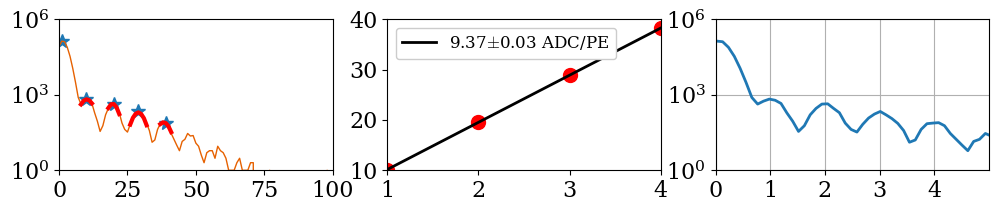

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_29.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


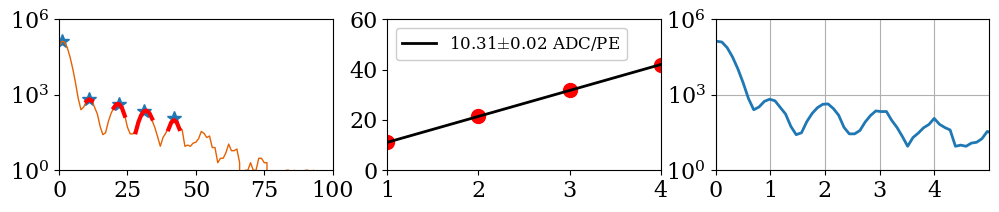

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


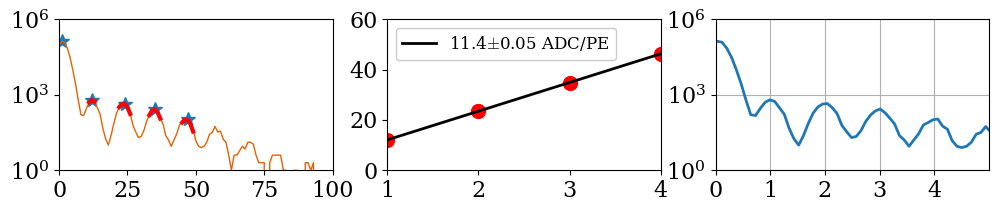

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_29.60OV_0.h5


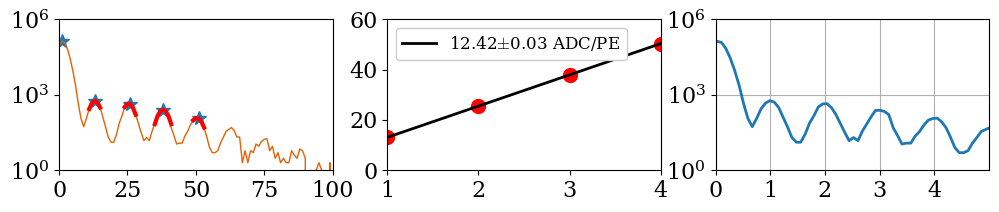

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_29.80OV_0.h5


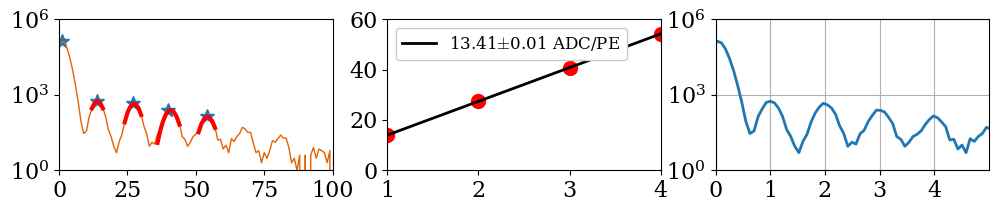

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_30.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


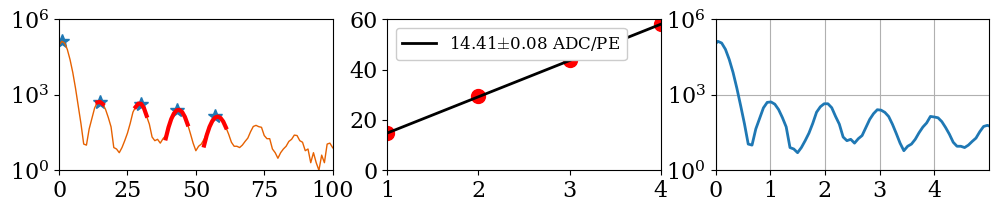

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_30.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


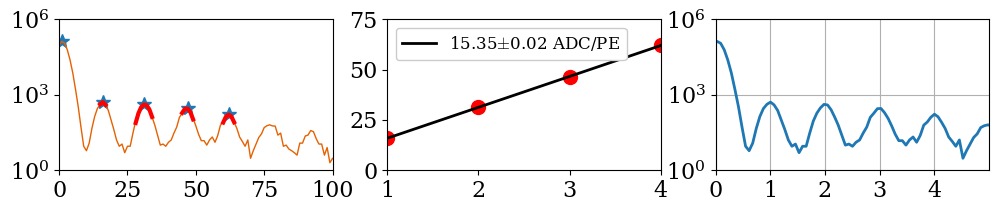

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


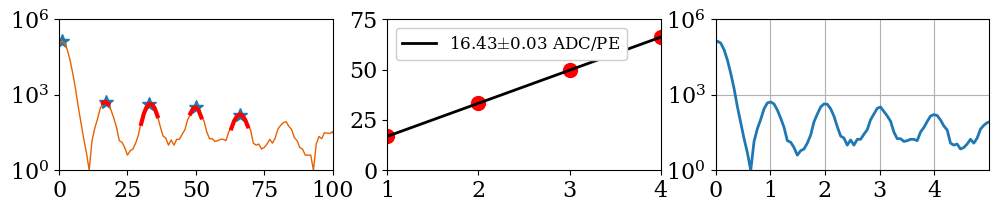

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_30.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


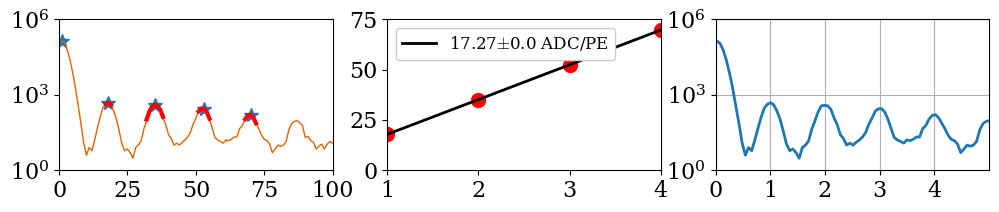

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_30.80OV_0.h5


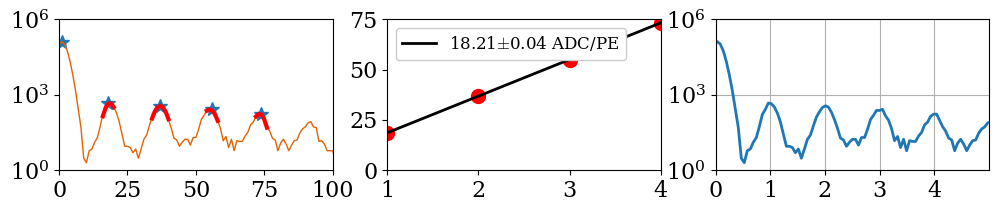

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_31.00OV_0.h5


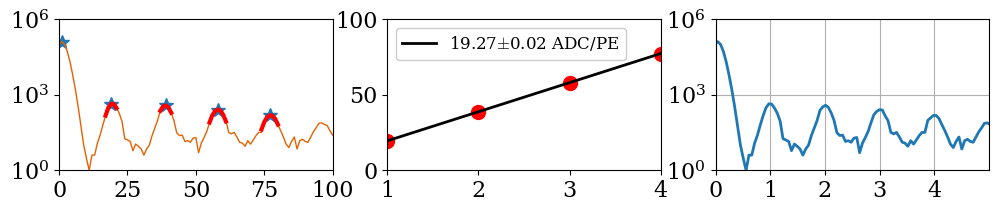

In [27]:
Step_14_calib_pe,Step_14_calib_count,Step_14_gain_list,Step_14_gain_err=gain_calculator(Step_14,40,4,1)
Voltages_Step_14=Voltages(Step_14)

In [28]:
Bins=40/5

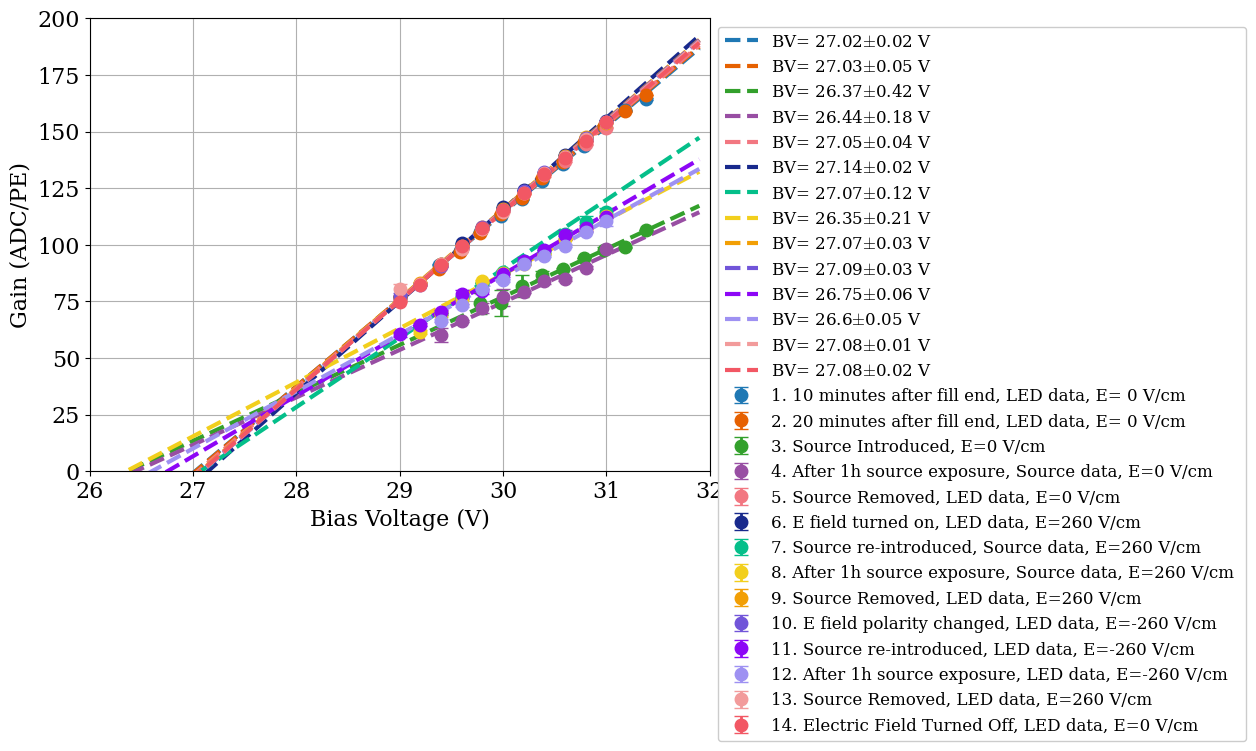

In [35]:
x_data=np.arange(26,32,0.1)
plt.figure(figsize=(8,6))

All_Voltages = [Voltages_Step_1, Voltages_Step_2, Voltages_Step_3, Voltages_Step_4, Voltages_Step_5, Voltages_Step_6, Voltages_Step_7,\
     Voltages_Step_8, Voltages_Step_9, Voltages_Step_10, Voltages_Step_11,Voltages_Step_12,Voltages_Step_13,Voltages_Step_14]
All_Gains = [Step_1_gain_list, Step_2_gain_list, Step_3_gain_list, Step_4_gain_list, Step_5_gain_list, Step_6_gain_list, Step_7_gain_list,\
     Step_8_gain_list, Step_9_gain_list, Step_10_gain_list, Step_11_gain_list, Step_12_gain_list, Step_13_gain_list, Step_14_gain_list]
All_Errors = [Step_1_gain_err, Step_2_gain_err, Step_3_gain_err, Step_4_gain_err, Step_5_gain_err, Step_6_gain_err, Step_7_gain_err,\
     Step_8_gain_err, Step_9_gain_err, Step_10_gain_err, Step_11_gain_err, Step_12_gain_err, Step_13_gain_err, Step_14_gain_err]
All_Bins = [Bins, Bins, Bins, Bins, Bins, Bins, 30/5 ,22/5, Bins, Bins, Bins, 30/5, Bins, Bins]
All_Labels = ['1. 10 minutes after fill end, LED data, E= 0 V/cm','2. 20 minutes after fill end, LED data, E= 0 V/cm', '3. Source Introduced, E=0 V/cm', '4. After 1h source exposure, Source data, E=0 V/cm','5. Source Removed, LED data, E=0 V/cm ','6. E field turned on, LED data, E=260 V/cm ',\
                '7. Source re-introduced, Source data, E=260 V/cm','8. After 1h source exposure, Source data, E=260 V/cm ','9. Source Removed, LED data, E=260 V/cm ','10. E field polarity changed, LED data, E=-260 V/cm ',\
                '11. Source re-introduced, LED data, E=-260 V/cm ','12. After 1h source exposure, LED data, E=-260 V/cm  ','13. Source Removed, LED data, E=260 V/cm ','14. Electric Field Turned Off, LED data, E=0 V/cm ']
Colours_all=[colors[i] for i in range(len(All_Voltages))]

for voltages, gains, errors, bins, labels, colours in zip(All_Voltages, All_Gains, All_Errors, All_Bins, All_Labels, Colours_all):
    plt.errorbar(voltages, gains*bins, yerr=errors*bins, label = labels, fmt='o', ms=9,color=colours)
    popt,pcov=curve_fit(line,voltages,gains*bins,p0=[31,26],sigma=errors*bins)
    label = 'BV= '+str(np.round(popt[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov)[1]),2))+' V'
    plt.plot(x_data, line(x_data,*popt), ls='--', label=label,color=colours,lw=3)

plt.grid()
plt.ylabel('Gain (ADC/PE)')
plt.xlabel('Bias Voltage (V)')
plt.legend(bbox_to_anchor =(1, 1))
# plt.legend(loc='best')
plt.ylim(0,200)
plt.xlim(26,32)
#     plt.savefig('BV_plot_{}_.pdf'.format(np.arange(1,14,1)))
plt.show()